# Predictive Model w/ Segmentation

## Setup

In [47]:
import pandas as pd
import pysam
import numpy as np
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import sqlite3
import csv
import glob
import gffpandas.gffpandas as gffpd
from intervaltree import Interval, IntervalTree
import bisect
from tqdm import tqdm
from biomart import BiomartServer
import os
import re
import gseapy as gp
from gseapy.plot import barplot, dotplot
from gseapy import GSEA
import statsmodels.api as sm
import statsmodels.stats.multitest as smm
from scipy.stats import kruskal, mannwhitneyu, ttest_ind, f_oneway, wilcoxon, ranksums, fisher_exact, chi2_contingency, entropy, pearsonr, zscore
import json
import ast
import itertools
import sys
from venn import venn
import contextlib
from imblearn.over_sampling import SMOTE
from upsetplot import from_contents, plot
import warnings
from sklearn.manifold import TSNE
from statsmodels.stats.multitest import multipletests
import shap
import pyranges as pr
from joblib import dump

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import DBSCAN

import importlib
import helper_functions

In [3]:
importlib.reload(helper_functions)
from helper_functions import *

# Initialize JavaScript environment
shap.initjs()

### Data Import

#### Metadata

In [4]:
metadata = pd.read_csv("/data/lvisser/metadata/ont_metadata.csv", sep = ",")
print(metadata.shape)
metadata.head()

(48, 16)


,run_id_rnaseq,run_id_ont,source_directory,sample_id_ori,sample_id_adj,sample_id_adj_rnaseq,cell_line_long,cell_line_short,tumor_type,bio_replicate,Group,L,batch,gender,age (months),barcode
0,RIMR14nov_R3_EKRN230005052.1A_HNYCWDSX5_L1_norRNA,OHMX20230016R_002,data_OHMX20230016R_20231114,RIMR14nov_R3,IMR14nov_R1,IMR14nov_R1,IMR-32,IMR,NB,1,S,L1,14/11/2024,male,13.0,barcode02
1,RIMR21nov_R3_EKRN230005053.1A_HNYCWDSX5_L1_norRNA,NaN,NaN,RIMR21nov_R3,IMR21nov_R2,NaN,IMR-32,IMR,NB,2,S,L1,21/11/2024,male,13.0,NaN
2,RIMR12dec_R3_EKRN230005054.1A_HNYCWDSX5_L1_norRNA,NaN,NaN,RIMR12dec_R3,IMR12dec_R3,NaN,IMR-32,IMR,NB,3,S,L1,12/12/2024,male,13.0,NaN
3,RIMR15dec_R3_EKRN230005055.1A_HNYCWDSX5_L1_norRNA,NaN,NaN,RIMR15dec_R3,IMR15dec_R4,NaN,IMR-32,IMR,NB,4,S,L1,15/12/2024,male,13.0,NaN
4,RSHP14nov_R1_EKRN230005048.1A_HNYCWDSX5_L1_norRNA,NaN,NaN,RSHP14nov_R1,SHP14nov_R1,NaN,SH-EP,SHP,NB,1,S,L1,14/11/2024,female,48.0,NaN


#### Gene Whitelist

In [5]:
whitelist = pd.read_csv("/data/lvisser/ferroptosis_gene_whitelists/complete_gene_list_no_duplicates.txt", index_col = 0)
whitelist.columns = ["gene_symbol"]
print(whitelist.shape)
whitelist.head()

(1271, 1)


,gene_symbol
1,NR4A1
2,NR4A2
3,NR4A3
4,ACACA
5,ACLY


#### DE Genes

In [6]:
DEG_full = pd.read_csv("/data/lvisser/DE_genes/DE_results_human_Group_R_S_full.csv")
DEG_full = DEG_full[DEG_full["padj"] < 0.05]
DEG_full = DEG_full.rename(columns = {DEG_full.columns[0]: "Gene", "name": "gene_symbol"}).reset_index(drop = True).sort_values("gene_symbol")
print(DEG_full.shape)
DEG_full.head()

(8488, 51)


,Gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,IMR14nov_R1,SHY2sept_R1,SKN10nov_R1,SHP14nov_R1,...,SH-SY5Y_C1,SH-SY5Y_J2,SH-SY5Y_J4,SH-SY5Y_C4,SH-SY5Y_J3,SH-SY5Y_J1,SH-SY5Y_C3,gene_symbol,type,description
6191,ENSG00000268895,109.118613,1.231726,0.705169,2.781499e-03,0.014594,198.323394,91.560461,165.733760,149.289871,...,64.677340,147.940128,124.847573,63.303751,144.163675,132.674599,84.841380,A1BG-AS1,lncRNA,A1BG antisense RNA 1 [Source:HGNC Symbol;Acc:H...
1837,ENSG00000128274,186.925118,-4.550350,1.181914,1.108199e-06,0.000020,0.922434,0.000000,3.682972,1154.084822,...,1.043183,0.000000,0.000000,0.000000,0.000000,2.567895,0.000000,A4GALT,protein_coding,"alpha 1,4-galactosyltransferase (P blood group..."
4357,ENSG00000242908,8.323454,-3.936345,2.903493,4.346391e-04,0.003240,0.000000,0.000000,0.000000,95.291407,...,0.000000,0.000000,0.000000,1.055063,0.000000,0.855965,0.000000,AADACL2-AS1,lncRNA,AADACL2 antisense RNA 1 [Source:HGNC Symbol;Ac...
1568,ENSG00000129673,25.946025,-1.413103,0.318514,3.030699e-07,0.000006,95.933177,6.104031,17.187205,10.587934,...,5.215914,3.735862,2.496951,10.550625,4.219425,2.567895,5.953781,AANAT,protein_coding,aralkylamine N-acetyltransferase [Source:HGNC ...
1479,ENSG00000008311,818.446853,-1.918062,0.400305,2.025127e-07,0.000004,1191.785231,79.352400,214.840059,4884.214022,...,126.225131,279.442464,342.082349,136.103064,341.070157,273.908850,167.450093,AASS,protein_coding,aminoadipate-semialdehyde synthase [Source:HGN...


In [7]:
DEG_MM = pd.read_csv("/data/lvisser/DE_genes/DE_results_human_Group_R_S_MM.csv")
DEG_MM = DEG_MM[DEG_MM["padj"] < 0.05]
DEG_MM = DEG_MM.rename(columns = {DEG_MM.columns[0]: "Gene", "name": "gene_symbol"}).reset_index(drop = True).sort_values("gene_symbol")
print(DEG_MM.shape)
DEG_MM.head()

(10513, 25)


,Gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,RPMI8226_1_3b,JJN3_1_3b,OPM_4_1,MM1R_1_2,...,MM1R_3_1,MM1R_2_2,RPMI8226_2_3b,JJN3_2_2b,JJN3_3_3b,RPMI8226_3_2b,MM1R_4_2,gene_symbol,type,description
1400,ENSG00000121410,7.014971,5.552054,0.881142,3.236431e-11,6.644271e-10,30.772996,4.387573,0.000000,0.727842,...,0.000000,0.000000,4.439469,19.874979,18.699434,10.235900,0.000000,A1BG,protein_coding,alpha-1-B glycoprotein [Source:HGNC Symbol;Acc...
179,ENSG00000268895,53.074171,8.849115,0.774549,3.377764e-32,5.397292e-30,121.553335,73.711227,0.000000,0.000000,...,0.000000,0.000000,71.031509,177.284812,113.009624,79.693789,0.000000,A1BG-AS1,lncRNA,A1BG antisense RNA 1 [Source:HGNC Symbol;Acc:H...
8748,ENSG00000148584,4.744162,1.489638,0.896618,6.471468e-03,2.127470e-02,0.769325,6.142602,1.625325,0.000000,...,5.721027,0.823753,16.648010,3.974996,4.878113,21.934070,1.828777,A1CF,protein_coding,APOBEC1 complementation factor [Source:HGNC Sy...
9793,ENSG00000175899,2.744737,-1.904452,1.547904,1.234374e-02,3.624637e-02,0.000000,0.000000,0.812662,9.461943,...,17.163082,9.885031,0.000000,3.179997,0.000000,0.000000,1.828777,A2M,protein_coding,alpha-2-macroglobulin [Source:HGNC Symbol;Acc:...
8567,ENSG00000128274,196.668642,2.250318,1.534502,5.737457e-03,1.926012e-02,748.553130,7.897631,0.000000,53.132449,...,75.326858,46.953897,9.988806,704.369253,703.261329,12.429307,47.548195,A4GALT,protein_coding,"alpha 1,4-galactosyltransferase (P blood group..."


In [8]:
DEG_NB = pd.read_csv("/data/lvisser/DE_genes/DE_results_human_Group_R_S_NB.csv")
DEG_NB = DEG_NB[DEG_NB["padj"] < 0.05]
DEG_NB = DEG_NB.rename(columns = {DEG_NB.columns[0]: "Gene", "name": "gene_symbol"}).reset_index(drop = True).sort_values("gene_symbol")
print(DEG_NB.shape)
DEG_NB.head()

(8362, 35)


,Gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,IMR14nov_R1,SHY2sept_R1,SKN10nov_R1,SHP14nov_R1,...,SH-SY5Y_C1,SH-SY5Y_J2,SH-SY5Y_J4,SH-SY5Y_C4,SH-SY5Y_J3,SH-SY5Y_J1,SH-SY5Y_C3,gene_symbol,type,description
5338,ENSG00000121410,43.403148,-0.703134,0.282696,1.270573e-03,7.467374e-03,99.622914,20.346769,33.146752,41.292943,...,13.561378,38.105791,26.217990,18.991125,42.194246,29.958781,33.490019,A1BG,protein_coding,alpha-1-B glycoprotein [Source:HGNC Symbol;Acc...
3589,ENSG00000175899,10.902600,2.421982,0.806641,9.738070e-05,8.514165e-04,5.534606,18.312092,1.227657,1.058793,...,33.381853,23.162343,11.236282,13.715813,21.800361,20.543164,32.745796,A2M,protein_coding,alpha-2-macroglobulin [Source:HGNC Symbol;Acc:...
6417,ENSG00000256069,3.489697,1.528053,0.946759,3.738377e-03,1.828207e-02,0.000000,3.052015,1.227657,4.235174,...,1.043183,2.241517,4.993903,6.330375,5.625899,5.991756,4.465336,A2MP1,transcribed_unprocessed_pseudogene,alpha-2-macroglobulin pseudogene 1 [Source:HGN...
841,ENSG00000128274,180.929104,-7.278222,1.117654,3.352751e-12,1.246874e-10,0.922434,0.000000,3.682972,1154.084822,...,1.043183,0.000000,0.000000,0.000000,0.000000,2.567895,0.000000,A4GALT,protein_coding,"alpha 1,4-galactosyltransferase (P blood group..."
5986,ENSG00000242908,13.445579,-3.317788,2.683701,2.529103e-03,1.325931e-02,0.000000,0.000000,0.000000,95.291407,...,0.000000,0.000000,0.000000,1.055063,0.000000,0.855965,0.000000,AADACL2-AS1,lncRNA,AADACL2 antisense RNA 1 [Source:HGNC Symbol;Ac...


## Segmentations

### Promotor Regions (Ensembl Regulatory Features GFF)

In [9]:
gff_file = "/data/lvisser/Ensembl/homo_sapiens.GRCh38.Regulatory_Build.regulatory_features.20210107.gff"

rf = gffpd.read_gff3(gff_file)
rf_df = pd.DataFrame(rf.df)

subattributes = rf_df['attributes'].str.split(';', expand=True)

for i in range(subattributes.shape[1]):
    subattribute = subattributes[i].str.split('=', expand=True)
    rf_df[subattribute[0].iloc[0]] = subattribute[1]

rf_df = rf_df.drop('attributes', axis = 1)

rf_df.to_csv('segmentations/all_rf_grch38.csv', index=False)
rf_df.head()

/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/gffpandas/gffpandas.py:32: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_table(self._gff_file, comment='#',


,seq_id,source,type,start,end,score,strand,phase,ID,bound_end,bound_start,description,feature_type
0,GL000008.2,Regulatory_Build,open_chromatin_region,103733,104006,.,.,.,open_chromatin_region:ENSR00000898744,104006,103733,Open chromatin region,Open chromatin
1,GL000008.2,Regulatory_Build,open_chromatin_region,106249,106503,.,.,.,open_chromatin_region:ENSR00000898745,106503,106249,Open chromatin region,Open chromatin
2,GL000008.2,Regulatory_Build,open_chromatin_region,112878,113287,.,.,.,open_chromatin_region:ENSR00000898746,113287,112878,Open chromatin region,Open chromatin
3,GL000008.2,Regulatory_Build,open_chromatin_region,134012,134308,.,.,.,open_chromatin_region:ENSR00000898747,134308,134012,Open chromatin region,Open chromatin
4,GL000008.2,Regulatory_Build,open_chromatin_region,138112,138274,.,.,.,open_chromatin_region:ENSR00001290160,138274,138112,Open chromatin region,Open chromatin


In [10]:
grch38 = pd.read_csv('/data/lvisser/Ensembl/GRCh38.tsv', sep='\t', header = None)
grch38.columns = ["chrom", "total_length(bp)", "GenBank_accession", "RefSeq_accession"]
grch38.head()

,chrom,total_length(bp),GenBank_accession,RefSeq_accession
0,1,"248,956,422",CM000663.2,NC_000001.11
1,2,"242,193,529",CM000664.2,NC_000002.12
2,3,"198,295,559",CM000665.2,NC_000003.12
3,4,"190,214,555",CM000666.2,NC_000004.12
4,5,"181,538,259",CM000667.2,NC_000005.10


In [11]:
# Replace 'file.sga' with the path to your SGA file
epd_df = pd.read_csv('/data/lvisser/EPD/Hs_EPDnew.sga', sep='\t')
epd_df.columns = ["RefSeq_accession", "type", "position", "strand", "idk", "promotorID"]
epd_df = epd_df.merge(grch38[["chrom", "RefSeq_accession"]], on = "RefSeq_accession", how = "left")
epd_df["gene_symbol"] = epd_df["promotorID"].str.split("_", expand = True)[0]
epd_df["chrom"] = "chr" + epd_df["chrom"].astype(str)

# Print the first few rows of the DataFrame
print(epd_df.shape)
epd_df.head()

(29597, 8)


,RefSeq_accession,type,position,strand,idk,promotorID,chrom,gene_symbol
0,NC_000001.11,TSS,960633,+,1,KLHL17_1,chr1,KLHL17
1,NC_000001.11,TSS,966482,+,1,PLEKHN1_1,chr1,PLEKHN1
2,NC_000001.11,TSS,976681,-,1,PERM1_1,chr1,PERM1
3,NC_000001.11,TSS,1000097,-,1,HES4_1,chr1,HES4
4,NC_000001.11,TSS,1000511,+,1,ISG15_2,chr1,ISG15


In [12]:
rf_promotors = rf_df[rf_df['type'] == 'promoter'].copy()
rf_promotors['seq_id'] = "chr" + rf_promotors['seq_id'].astype(str)
rf_promotors = rf_promotors.rename(columns = {"seq_id": "chrom"})
rf_promotors['segment_id'] = rf_promotors['chrom'].astype(str) + ':' + rf_promotors['start'].astype(str) + '-' + rf_promotors['end'].astype(str)
rf_promotors['region'] = pd.IntervalIndex.from_arrays(rf_promotors['start'], rf_promotors['end'], closed='both')
rf_promotors["length"] = rf_promotors["end"] - rf_promotors["start"]

rf_promotors.to_csv("/data/lvisser/segmentations/rf_promotors_grch38.csv", index=False)

grouped = rf_promotors.groupby('chrom')

# Create an IntervalTree for each group
promotor_trees = {str(seq_id): IntervalTree(Interval(row.start, row.end, row.segment_id) for row in group.itertuples()) for seq_id, group in grouped}

# Convert rf_promotors to a dictionary for faster lookups
rf_promotors_dict = rf_promotors.set_index('segment_id').to_dict('index')

rf_promotors_genes_list = []

for chrom in epd_df["chrom"].unique():
    epd_df_slice = epd_df[epd_df["chrom"] == chrom]
    tree = promotor_trees[chrom]
    for row in epd_df_slice.itertuples():
        intervals = tree[row.position]
        for interval in intervals:
            new_row = rf_promotors_dict[interval.data].copy()
            new_row["segment_id"] = interval.data  # Add 'segment_id' to the new row
            new_row["gene_symbol"] = row.gene_symbol
            rf_promotors_genes_list.append(new_row)

rf_promotors_genes = pd.DataFrame(rf_promotors_genes_list)
rf_promotors_genes = rf_promotors_genes.drop_duplicates()

rf_promotors_genes.to_csv("/data/lvisser/segmentations/rf_promotors_genes.csv", index=False)

In [13]:
rf_promotors_genes = pd.read_csv('/data/lvisser/segmentations/rf_promotors_genes.csv')
print(rf_promotors_genes.shape)
rf_promotors_genes.head()

(16525, 17)


,chrom,source,type,start,end,score,strand,phase,ID,bound_end,bound_start,description,feature_type,region,length,segment_id,gene_symbol
0,chr1,Regulatory_Build,promoter,957600,962001,.,.,.,promoter:ENSR00000000111,963999,956402,Predicted promoter,Promoter,"[957600, 962001]",4401,chr1:957600-962001,KLHL17
1,chr1,Regulatory_Build,promoter,965800,967601,.,.,.,promoter:ENSR00000000112,968199,965402,Predicted promoter,Promoter,"[965800, 967601]",1801,chr1:965800-967601,PLEKHN1
2,chr1,Regulatory_Build,promoter,975600,977201,.,.,.,promoter:ENSR00000344444,978843,975202,Predicted promoter,Promoter,"[975600, 977201]",1601,chr1:975600-977201,PERM1
3,chr1,Regulatory_Build,promoter,997400,1002401,.,.,.,promoter:ENSR00000000118,1007399,995602,Predicted promoter,Promoter,"[997400, 1002401]",5001,chr1:997400-1002401,HES4
4,chr1,Regulatory_Build,promoter,997400,1002401,.,.,.,promoter:ENSR00000000118,1007399,995602,Predicted promoter,Promoter,"[997400, 1002401]",5001,chr1:997400-1002401,ISG15


In [14]:
rf_promotors_DEG = rf_promotors_genes[rf_promotors_genes["gene_symbol"].isin(DEG_full["gene_symbol"])].drop_duplicates()
rf_promotors_DEG.to_csv('/data/lvisser/segmentations/rf_promotors_DEG.csv', index=False)

In [15]:
rf_promotors_DEG = pd.read_csv('/data/lvisser/segmentations/rf_promotors_DEG.csv')
print(rf_promotors_DEG.shape)
rf_promotors_DEG.head()

(5182, 17)


,chrom,source,type,start,end,score,strand,phase,ID,bound_end,bound_start,description,feature_type,region,length,segment_id,gene_symbol
0,chr1,Regulatory_Build,promoter,957600,962001,.,.,.,promoter:ENSR00000000111,963999,956402,Predicted promoter,Promoter,"[957600, 962001]",4401,chr1:957600-962001,KLHL17
1,chr1,Regulatory_Build,promoter,997400,1002401,.,.,.,promoter:ENSR00000000118,1007399,995602,Predicted promoter,Promoter,"[997400, 1002401]",5001,chr1:997400-1002401,HES4
2,chr1,Regulatory_Build,promoter,1211800,1218201,.,.,.,promoter:ENSR00000344538,1218599,1211002,Predicted promoter,Promoter,"[1211800, 1218201]",6401,chr1:1211800-1218201,TNFRSF4
3,chr1,Regulatory_Build,promoter,1304000,1310601,.,.,.,promoter:ENSR00000344573,1311199,1302402,Predicted promoter,Promoter,"[1304000, 1310601]",6601,chr1:1304000-1310601,ACAP3
4,chr1,Regulatory_Build,promoter,1397800,1401201,.,.,.,promoter:ENSR00000000186,1406599,1397202,Predicted promoter,Promoter,"[1397800, 1401201]",3401,chr1:1397800-1401201,CCNL2


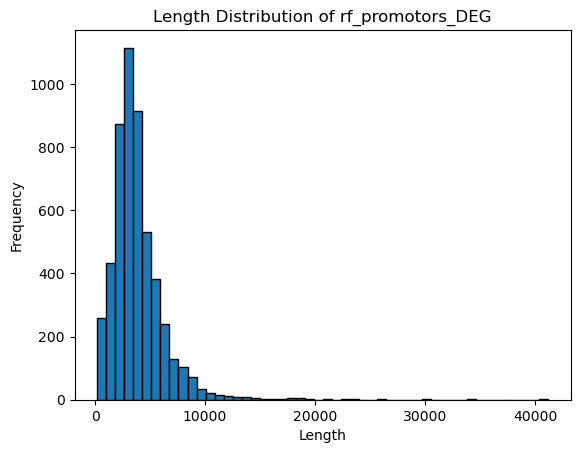

In [16]:
# Assuming 'length' is the column with the lengths
lengths = rf_promotors_DEG['length']

plt.hist(lengths, bins=50, edgecolor='black')
plt.title('Length Distribution of rf_promotors_DEG')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

### Gene Bodies

In [17]:
gene_bodies_df = pd.read_csv("/data/lvisser/Ensembl/gene_bodies_105.txt", sep = "\t", dtype={6: str})
gene_bodies_df.head()

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene start (bp),Gene end (bp),Chromosome/scaffold name,Transcription start site (TSS),Gene name,Gene description
0,ENSG00000210049,ENSG00000210049.1,ENST00000387314,ENST00000387314.1,577,647,MT,577,MT-TF,mitochondrially encoded tRNA-Phe (UUU/C) [Sour...
1,ENSG00000211459,ENSG00000211459.2,ENST00000389680,ENST00000389680.2,648,1601,MT,648,MT-RNR1,mitochondrially encoded 12S rRNA [Source:HGNC ...
2,ENSG00000210077,ENSG00000210077.1,ENST00000387342,ENST00000387342.1,1602,1670,MT,1602,MT-TV,mitochondrially encoded tRNA-Val (GUN) [Source...
3,ENSG00000210082,ENSG00000210082.2,ENST00000387347,ENST00000387347.2,1671,3229,MT,1671,MT-RNR2,mitochondrially encoded 16S rRNA [Source:HGNC ...
4,ENSG00000209082,ENSG00000209082.1,ENST00000386347,ENST00000386347.1,3230,3304,MT,3230,MT-TL1,mitochondrially encoded tRNA-Leu (UUA/G) 1 [So...


In [18]:
gene_bodies_105 = gene_bodies_df[["Gene start (bp)", "Gene end (bp)", "Chromosome/scaffold name", "Gene name"]].copy().dropna()
gene_bodies_105.columns = ["start", "end", "chrom", "gene_symbol"]
gene_bodies_105["chrom"] = "chr" + gene_bodies_105["chrom"]
valid_chromosomes = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY', 'chrMT']
gene_bodies_105 = gene_bodies_105[gene_bodies_105['chrom'].isin(valid_chromosomes)]
gene_bodies_105["segment_id"] = gene_bodies_105["chrom"] + ":" + gene_bodies_105["start"].astype(str) + "-" + gene_bodies_105["end"].astype(str)
gene_bodies_105["length"] = gene_bodies_105["end"] - gene_bodies_105["start"]
# Remove rows with duplicate 'gene_symbol' values
gene_bodies_105 = gene_bodies_105.drop_duplicates(subset='gene_symbol')
gene_bodies_105.drop_duplicates().to_csv("/data/lvisser/segmentations/gene_bodies_105.csv", index=False)

In [19]:
gene_bodies_105 = pd.read_csv("/data/lvisser/segmentations/gene_bodies_105.csv", dtype={2: str})
print(gene_bodies_105.shape)
gene_bodies_105.head()

(39620, 6)


,start,end,chrom,gene_symbol,segment_id,length
0,577,647,chrMT,MT-TF,chrMT:577-647,70
1,648,1601,chrMT,MT-RNR1,chrMT:648-1601,953
2,1602,1670,chrMT,MT-TV,chrMT:1602-1670,68
3,1671,3229,chrMT,MT-RNR2,chrMT:1671-3229,1558
4,3230,3304,chrMT,MT-TL1,chrMT:3230-3304,74


In [20]:
gene_bodies_DEG = gene_bodies_105[gene_bodies_105["gene_symbol"].isin(DEG_full["gene_symbol"])]
gene_bodies_DEG.to_csv("/data/lvisser/segmentations/gene_bodies_DEG.csv", index=False)

In [21]:
gene_bodies_DEG = pd.read_csv("/data/lvisser/segmentations/gene_bodies_DEG.csv")
print(gene_bodies_DEG.shape)
gene_bodies_DEG.head()

(6925, 6)


,start,end,chrom,gene_symbol,segment_id,length
0,648,1601,chrMT,MT-RNR1,chrMT:648-1601,953
1,1602,1670,chrMT,MT-TV,chrMT:1602-1670,68
2,1671,3229,chrMT,MT-RNR2,chrMT:1671-3229,1558
3,4402,4469,chrMT,MT-TM,chrMT:4402-4469,67
4,5587,5655,chrMT,MT-TA,chrMT:5587-5655,68


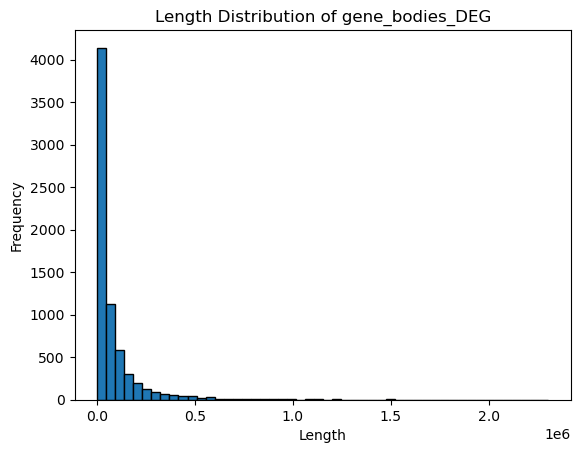

In [22]:
# Assuming 'length' is the column with the lengths
lengths = gene_bodies_DEG['length']

plt.hist(lengths, bins=50, edgecolor='black')
plt.title('Length Distribution of gene_bodies_DEG')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

### WGBS_tools

#### NB

In [22]:
# Call the function
folder = "/data/lvisser/wgbs_tools/outputs/segmentations/NB1_only/unfiltered"
wgbs_seg_nb1 = process_wgbs_seg_files(folder)
wgbs_seg_nb1 = find_annot_overlap(wgbs_seg_nb1, rf_promotors_genes)
wgbs_seg_nb1.to_csv("/data/lvisser/feature_matrices/wgbs_seg_nb1.csv", index = False)

In [23]:
wgbs_seg_nb1 = pd.read_csv("/data/lvisser/feature_matrices/wgbs_seg_nb1.csv")
print(wgbs_seg_nb1.shape)
wgbs_seg_nb1.head()

(1895562, 11)


,chrom,start,end,startCpG,endCpG,IMR14nov_R1,SHP12dec_R4,SHY2sept_R1,SKN14nov_R2,segment_id,gene_symbol
0,chr22,10510235,10512049,27218094,27218104,0.88,0.04,0.04,0.06,chr22:10510235-10512049,NaN
1,chr22,10513853,10515736,27218105,27218120,0.92,0.02,0.08,0.07,chr22:10513853-10515736,NaN
2,chr22,10516017,10517750,27218120,27218125,1.00,0.15,0.00,0.00,chr22:10516017-10517750,NaN
3,chr22,10518304,10520219,27218125,27218137,1.00,0.00,0.00,0.09,chr22:10518304-10520219,NaN
4,chr22,10520752,10522650,27218139,27218150,NaN,0.11,0.00,0.06,chr22:10520752-10522650,NaN


In [24]:
meth_seg_wgbs_nb1_fm = create_fm_wgbs(wgbs_seg_nb1, metadata)
meth_seg_wgbs_nb1_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_nb1_fm.csv", index = False)
print(meth_seg_wgbs_nb1_fm.shape)
meth_seg_wgbs_nb1_fm.head()

(4, 1546160)


,sample_id_adj,chr22:10510235-10512049,chr22:10513853-10515736,chr22:10516017-10517750,chr22:10518304-10520219,chr22:10522965-10524772,chr22:10525487-10525747,chr22:10525749-10525908,chr22:10525917-10525931,chr22:10525943-10526051,...,chr9:138243659-138245623,chr9:138256043-138257768,chr9:138258705-138260224,chr9:138301800-138302861,chr9:138303904-138304191,chr9:138314410-138315821,chr9:138316464-138318349,source_directory,Group,tumor_type
0,IMR14nov_R1,0.88,0.92,1.00,1.00,1.00,1.00,0.97,1.00,0.89,...,0.95,0.67,0.84,1.00,1.00,0.85,0.14,data_OHMX20230016R_20231114,S,NB
1,SHP12dec_R4,0.04,0.02,0.15,0.00,0.04,0.84,0.96,0.89,0.91,...,0.00,0.00,0.00,0.25,0.86,0.09,0.00,data_OHMX20230016R_20231114,S,NB
2,SHY2sept_R1,0.04,0.08,0.00,0.00,0.00,0.81,0.56,0.34,0.62,...,0.88,1.00,1.00,0.80,0.93,1.00,1.00,data_OHMX20230016R_20231114,R,NB
3,SKN14nov_R2,0.06,0.07,0.00,0.09,0.02,0.71,0.59,0.17,0.74,...,0.37,0.00,0.16,0.23,0.40,0.33,0.11,data_OHMX20230016R_20231114,R,NB


In [25]:
# Call the function
folder = '/data/lvisser/wgbs_tools/outputs/dmr/NB1_only/unfiltered'  # replace with your folder
wgbs_dmr_nb1 = process_wgbs_dmr_files(folder)
wgbs_dmr_nb1 = find_annot_overlap(wgbs_dmr_nb1, rf_promotors_genes)
wgbs_dmr_nb1.to_csv("/data/lvisser/feature_matrices/wgbs_dmr_nb1.csv", index = False)

In [26]:
wgbs_dmr_nb1 = pd.read_csv("/data/lvisser/feature_matrices/wgbs_dmr_nb1.csv")
print(wgbs_dmr_nb1.shape)
wgbs_dmr_nb1.head()

(37200, 18)


,chrom,start,end,startCpG,endCpG,target,segment_id,lenCpG,bp,tg_mean,bg_mean,delta_means,delta_quants,delta_maxmin,ttest,direction,length,gene_symbol
0,chr8,339324,339424,12448810,12448816,R,chr8:339324-339424,6CpGs,100bp,0.1650,0.746,0.581,0.457,0.404,0.0442,U,100,NaN
1,chr8,636727,636822,12453158,12453162,R,chr8:636727-636822,4CpGs,95bp,0.3810,0.882,0.501,0.471,0.446,0.0091,U,95,NaN
2,chr8,1373259,1373562,12470337,12470371,R,chr8:1373259-1373562,34CpGs,303bp,0.0185,0.813,0.794,0.707,0.693,0.0111,U,303,NaN
3,chr8,1956798,1957098,12483994,12484007,R,chr8:1956798-1957098,13CpGs,300bp,0.1170,0.909,0.792,0.684,0.658,0.0157,U,300,NaN
4,chr8,1958036,1958341,12484025,12484039,R,chr8:1958036-1958341,14CpGs,305bp,0.0329,0.607,0.574,0.503,0.499,0.0160,U,305,NaN


#### MM

In [27]:
# Call the function
folder = "/data/lvisser/wgbs_tools/outputs/segmentations/MM1_only/unfiltered"
wgbs_seg_mm1 = process_wgbs_seg_files(folder)
wgbs_seg_mm1 = find_annot_overlap(wgbs_seg_mm1, rf_promotors_genes)
wgbs_seg_mm1.to_csv("/data/lvisser/feature_matrices/wgbs_seg_mm1.csv", index = False)

In [28]:
wgbs_seg_mm1 = pd.read_csv("/data/lvisser/feature_matrices/wgbs_seg_mm1.csv")
print(wgbs_seg_mm1.shape)
wgbs_seg_mm1.head()

(2436165, 11)


,chrom,start,end,startCpG,endCpG,JJN3_2_1,MM1R_4_3,OPM_4_3,RPMI8226_3_3,segment_id,gene_symbol
0,chr22,10510235,10511697,27218094,27218102,0.22,0.8,NaN,1.0,chr22:10510235-10511697,NaN
1,chr22,10512833,10514603,27218104,27218110,0.30,1.0,NaN,0.9,chr22:10512833-10514603,NaN
2,chr22,10514792,10514994,27218110,27218115,NaN,NaN,NaN,NaN,chr22:10514792-10514994,NaN
3,chr22,10515170,10517014,27218115,27218124,0.25,NaN,NaN,1.0,chr22:10515170-10517014,NaN
4,chr22,10517749,10518350,27218124,27218127,NaN,NaN,NaN,NaN,chr22:10517749-10518350,NaN


In [29]:
meth_seg_wgbs_mm1_fm = create_fm_wgbs(wgbs_seg_mm1, metadata)
meth_seg_wgbs_mm1_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_mm1_fm.csv", index = False)
print(meth_seg_wgbs_mm1_fm.shape)
meth_seg_wgbs_mm1_fm.head()

(4, 1640061)


,sample_id_adj,chr22:10519035-10520844,chr22:10523473-10525269,chr22:10525487-10525946,chr22:10525988-10526067,chr22:10526102-10526125,chr22:10526140-10526194,chr22:10526196-10526215,chr22:10526238-10526899,chr22:10526908-10528747,...,chr9:138230113-138231335,chr9:138231458-138231709,chr9:138231832-138232715,chr9:138232777-138234470,chr9:138234559-138235402,chr9:138235579-138237577,chr9:138258705-138259649,source_directory,Group,tumor_type
0,JJN3_2_1,0.04,0.25,0.71,0.48,0.24,0.68,0.27,0.66,0.79,...,0.00,0.16,0.01,0.10,0.08,0.11,0.27,data_OHMX20230016R_MM_2,R,MM
1,MM1R_4_3,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.98,0.98,...,0.00,0.40,0.59,0.45,0.08,0.53,0.38,data_OHMX20230016R_MM_2,S,MM
2,OPM_4_3,0.00,0.30,0.58,1.00,0.25,0.78,0.12,0.46,0.44,...,0.02,0.50,0.44,0.32,0.27,0.14,0.00,data_OHMX20230016R_MM_2,S,MM
3,RPMI8226_3_3,1.00,1.00,1.00,0.97,1.00,0.90,1.00,0.98,0.99,...,0.03,0.29,0.19,0.07,0.09,0.20,0.00,data_OHMX20230016R_MM_2,R,MM


In [30]:
# Call the function
folder = '/data/lvisser/wgbs_tools/outputs/dmr/MM1_only/unfiltered'  # replace with your folder
wgbs_dmr_mm1 = process_wgbs_dmr_files(folder)
wgbs_dmr_mm1 = find_annot_overlap(wgbs_dmr_mm1, rf_promotors_genes)
wgbs_dmr_mm1.to_csv("/data/lvisser/feature_matrices/wgbs_dmr_mm1.csv", index = False)

In [31]:
wgbs_dmr_mm1 = pd.read_csv("/data/lvisser/feature_matrices/wgbs_dmr_mm1.csv")
print(wgbs_dmr_mm1.shape)
wgbs_dmr_mm1.head()

(51158, 18)


,chrom,start,end,startCpG,endCpG,target,segment_id,lenCpG,bp,tg_mean,bg_mean,delta_means,delta_quants,delta_maxmin,ttest,direction,length,gene_symbol
0,chr8,735644,735839,12456016,12456020,R,chr8:735644-735839,4CpGs,195bp,0.0417,0.366,0.324,0.295,0.274,0.01680,U,195,NaN
1,chr8,744182,744209,12456453,12456456,R,chr8:744182-744209,3CpGs,27bp,0.3100,0.798,0.488,0.457,0.444,0.00406,U,27,NaN
2,chr8,1733185,1733229,12478474,12478479,R,chr8:1733185-1733229,5CpGs,44bp,0.2150,0.909,0.694,0.600,0.587,0.01720,U,44,NaN
3,chr8,2033622,2033665,12486006,12486011,R,chr8:2033622-2033665,5CpGs,43bp,0.6180,0.977,0.359,0.328,0.318,0.00651,U,43,NaN
4,chr8,2056508,2058050,12486478,12486516,R,chr8:2056508-2058050,38CpGs,1542bp,0.3610,0.937,0.576,0.513,0.462,0.02970,U,1542,NaN


#### Roberto

In [37]:
# Call the function
folder = "/data/lvisser/wgbs_tools/outputs/segmentations/roberto_only/unfiltered"
wgbs_seg_rob = process_wgbs_seg_files(folder)
wgbs_seg_rob = find_annot_overlap(wgbs_seg_rob, rf_promotors_genes)
wgbs_seg_rob.to_csv("/data/lvisser/feature_matrices/wgbs_seg_rob.csv", index = False)

In [38]:
wgbs_seg_rob = pd.read_csv("/data/lvisser/feature_matrices/wgbs_seg_rob.csv")
print(wgbs_seg_rob.shape)
wgbs_seg_rob.head()

(1751365, 11)


,chrom,start,end,startCpG,endCpG,SH-SY5Y_C1,SH-SY5Y_C2,SH-SY5Y_J1,SH-SY5Y_J2,segment_id,gene_symbol
0,chr22,10510235,10512049,27218094,27218104,0.14,0.03,0.03,0.00,chr22:10510235-10512049,NaN
1,chr22,10513853,10515736,27218105,27218120,0.04,0.08,0.00,0.00,chr22:10513853-10515736,NaN
2,chr22,10516385,10518350,27218122,27218127,0.12,0.00,0.00,0.06,chr22:10516385-10518350,NaN
3,chr22,10519035,10520844,27218127,27218141,0.00,0.21,0.05,0.04,chr22:10519035-10520844,NaN
4,chr22,10521531,10523474,27218142,27218153,0.04,0.03,0.06,0.00,chr22:10521531-10523474,NaN


In [42]:
meth_seg_wgbs_rob_fm = create_fm_wgbs(wgbs_seg_rob, metadata)
meth_seg_wgbs_rob_fm['Group'] = meth_seg_wgbs_rob_fm['Group'].replace('Ss', 'S')
meth_seg_wgbs_rob_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_rob_fm.csv", index = False)
print(meth_seg_wgbs_rob_fm.shape)
meth_seg_wgbs_rob_fm.head()

(4, 1506198)


,sample_id_adj,chr22:10510235-10512049,chr22:10513853-10515736,chr22:10516385-10518350,chr22:10519035-10520844,chr22:10521531-10523474,chr22:10523565-10525269,chr22:10525487-10525647,chr22:10525675-10525733,chr22:10525744-10525753,...,chr9:138235444-138235580,chr9:138235594-138235838,chr9:138235928-138236338,chr9:138236806-138238555,chr9:138243705-138245697,chr9:138257561-138259442,chr9:138303904-138305610,source_directory,Group,tumor_type
0,SH-SY5Y_C1,0.14,0.04,0.12,0.00,0.04,0.04,0.74,0.81,0.68,...,1.00,0.56,0.94,0.74,0.80,0.90,1.00,data_OHMXroberto,R,NB
1,SH-SY5Y_C2,0.03,0.08,0.00,0.21,0.03,0.08,0.81,0.86,0.57,...,0.90,0.25,0.80,0.83,0.87,0.88,0.97,data_OHMXroberto,R,NB
2,SH-SY5Y_J1,0.03,0.00,0.00,0.05,0.06,0.09,0.80,0.69,0.62,...,1.00,0.45,0.77,0.79,0.96,0.90,0.95,data_OHMXroberto,S,NB
3,SH-SY5Y_J2,0.00,0.00,0.06,0.04,0.00,0.15,0.75,0.75,0.86,...,0.94,0.14,1.00,0.92,0.94,0.93,0.96,data_OHMXroberto,S,NB


#### NB + MM

In [32]:
# Call the function
folder = "/data/lvisser/wgbs_tools/outputs/segmentations/NB1_and_MM1/unfiltered"
wgbs_seg_nb1mm1 = process_wgbs_seg_files(folder)
wgbs_seg_nb1mm1 = find_annot_overlap(wgbs_seg_nb1mm1, rf_promotors_genes)
wgbs_seg_nb1mm1.to_csv("/data/lvisser/feature_matrices/wgbs_seg_nb1mm1.csv", index = False)

In [33]:
wgbs_seg_nb1mm1 = pd.read_csv("/data/lvisser/feature_matrices/wgbs_seg_nb1mm1.csv")
print(wgbs_seg_nb1mm1.shape)
wgbs_seg_nb1mm1.head()

(2032865, 15)


,chrom,start,end,startCpG,endCpG,SHP12dec_R4,SHY2sept_R1,IMR14nov_R1,SKN14nov_R2,JJN3_2_1,MM1R_4_3,RPMI8226_3_3,OPM_4_3,segment_id,gene_symbol
0,chr22,10510235,10512049,27218094,27218104,0.04,0.04,0.88,0.06,0.18,0.67,0.83,NaN,chr22:10510235-10512049,NaN
1,chr22,10513853,10515736,27218105,27218120,0.02,0.08,0.92,0.07,0.25,1.00,0.90,NaN,chr22:10513853-10515736,NaN
2,chr22,10516017,10517750,27218120,27218125,0.15,0.00,1.00,0.00,0.33,NaN,1.00,NaN,chr22:10516017-10517750,NaN
3,chr22,10518304,10520219,27218125,27218137,0.00,0.00,1.00,0.09,0.04,1.00,1.00,0.0,chr22:10518304-10520219,NaN
4,chr22,10520404,10520844,27218137,27218141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr22:10520404-10520844,NaN


In [34]:
meth_seg_wgbs_nb1mm1_fm = create_fm_wgbs(wgbs_seg_nb1mm1, metadata)
meth_seg_wgbs_nb1mm1_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_nb1mm1_fm.csv", index = False)
print(meth_seg_wgbs_nb1mm1_fm.shape)
meth_seg_wgbs_nb1mm1_fm.head()

(8, 1371922)


,sample_id_adj,chr22:10518304-10520219,chr22:10523473-10525269,chr22:10525487-10525747,chr22:10525749-10525946,chr22:10525988-10526067,chr22:10526088-10526125,chr22:10526140-10526166,chr22:10526193-10526215,chr22:10526292-10526901,...,chr9:138231832-138232715,chr9:138232777-138234470,chr9:138234518-138234560,chr9:138234662-138235402,chr9:138235579-138237577,chr9:138258705-138260224,chr9:138314410-138315935,source_directory,Group,tumor_type
0,SHP12dec_R4,0.00,0.04,0.84,0.95,0.79,0.88,0.70,0.92,0.83,...,0.20,0.16,0.79,0.16,0.33,0.00,0.11,data_OHMX20230016R_20231114,S,NB
1,SHY2sept_R1,0.00,0.19,0.81,0.55,0.49,0.24,0.73,0.35,0.56,...,0.59,0.72,0.38,0.38,0.73,1.00,0.86,data_OHMX20230016R_20231114,R,NB
2,IMR14nov_R1,1.00,1.00,1.00,0.98,0.93,1.00,1.00,1.00,0.98,...,0.80,0.84,0.80,0.62,0.89,0.84,0.73,data_OHMX20230016R_20231114,S,NB
3,SKN14nov_R2,0.09,0.16,0.71,0.56,0.72,0.25,0.82,0.07,0.44,...,0.33,0.24,0.25,0.00,0.25,0.16,0.30,data_OHMX20230016R_20231114,R,NB
4,JJN3_2_1,0.04,0.25,0.75,0.64,0.48,0.25,0.72,0.32,0.65,...,0.01,0.10,0.22,0.11,0.11,0.27,0.00,data_OHMX20230016R_MM_2,R,MM


#### NB + Roberto

In [23]:
# Call the function
folder = "/data/lvisser/wgbs_tools/outputs/segmentations/NB1_and_roberto/unfiltered"
wgbs_seg_nb1rob = process_wgbs_seg_files(folder)
wgbs_seg_nb1rob = find_annot_overlap(wgbs_seg_nb1rob, rf_promotors_genes)
wgbs_seg_nb1rob.to_csv("/data/lvisser/feature_matrices/wgbs_seg_nb1rob.csv", index = False)

In [24]:
wgbs_seg_nb1rob = pd.read_csv("/data/lvisser/feature_matrices/wgbs_seg_nb1rob.csv")
print(wgbs_seg_nb1rob.shape)
wgbs_seg_nb1rob.head()

(1780726, 15)


,chrom,start,end,startCpG,endCpG,SHP12dec_R4,SHY2sept_R1,IMR14nov_R1,SKN14nov_R2,SH-SY5Y_C2,SH-SY5Y_C1,SH-SY5Y_J1,SH-SY5Y_J2,segment_id,gene_symbol
0,chr22,10510235,10512049,27218094,27218104,0.04,0.04,0.88,0.06,0.03,0.14,0.03,0.00,chr22:10510235-10512049,NaN
1,chr22,10513853,10515736,27218105,27218120,0.02,0.08,0.92,0.07,0.08,0.04,0.00,0.00,chr22:10513853-10515736,NaN
2,chr22,10516017,10517750,27218120,27218125,0.15,0.00,1.00,0.00,0.08,0.10,0.00,0.10,chr22:10516017-10517750,NaN
3,chr22,10518304,10520219,27218125,27218137,0.00,0.00,1.00,0.09,0.20,0.00,0.04,0.04,chr22:10518304-10520219,NaN
4,chr22,10520404,10520844,27218137,27218141,NaN,NaN,NaN,NaN,NaN,NaN,0.09,0.00,chr22:10520404-10520844,NaN


In [30]:
meth_seg_wgbs_nb1rob_fm = create_fm_wgbs(wgbs_seg_nb1rob, metadata)
meth_seg_wgbs_nb1rob_fm['Group'] = meth_seg_wgbs_nb1rob_fm['Group'].replace('Ss', 'S')
meth_seg_wgbs_nb1rob_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_nb1rob_fm.csv", index = False)
print(meth_seg_wgbs_nb1rob_fm.shape)
meth_seg_wgbs_nb1rob_fm.head()

(8, 1396691)


,sample_id_adj,chr22:10510235-10512049,chr22:10513853-10515736,chr22:10516017-10517750,chr22:10518304-10520219,chr22:10521531-10523474,chr22:10523565-10525269,chr22:10525487-10525647,chr22:10525675-10525908,chr22:10525917-10525931,...,chr9:138235444-138235580,chr9:138235594-138235929,chr9:138236806-138238555,chr9:138243705-138245697,chr9:138256260-138258070,chr9:138258705-138260388,chr9:138303904-138305610,source_directory,Group,tumor_type
0,SHP12dec_R4,0.04,0.02,0.15,0.00,0.11,0.04,0.85,0.93,0.89,...,0.44,0.31,0.15,0.00,0.00,0.00,0.86,data_OHMX20230016R_20231114,S,NB
1,SHY2sept_R1,0.04,0.08,0.00,0.00,0.00,0.21,0.85,0.63,0.34,...,0.94,0.37,0.92,0.88,1.00,1.00,0.92,data_OHMX20230016R_20231114,R,NB
2,IMR14nov_R1,0.88,0.92,1.00,1.00,1.00,1.00,1.00,0.98,1.00,...,0.94,0.88,0.91,0.95,0.76,0.84,1.00,data_OHMX20230016R_20231114,S,NB
3,SKN14nov_R2,0.06,0.07,0.00,0.09,0.04,0.17,0.71,0.63,0.17,...,0.58,0.05,0.31,0.39,0.25,0.16,0.32,data_OHMX20230016R_20231114,R,NB
4,SH-SY5Y_C2,0.03,0.08,0.08,0.20,0.03,0.08,0.81,0.72,0.48,...,0.90,0.26,0.83,0.87,1.00,1.00,0.97,data_OHMXroberto,R,NB


## Feature Extraction/Reduction

### Annotation-Based

#### Promotor Regions

In [206]:
cpg_promotors_df = pd.read_csv("/data/lvisser/feature_matrices/concatenated_tables/all_samples/cpg_cat_all_unicvg.csv")
print(cpg_promotors_df.shape)
cpg_promotors_df.head()

(105555914, 6)


,chrom,ref_position,source_directory,sample_id_adj,cpg_coverage,mod_qual
0,chr15,17024844,data_OHMX20230016R_20231114,IMR14nov_R1,1,0.038086
1,chr15,17024908,data_OHMX20230016R_20231114,IMR14nov_R1,2,0.989258
2,chr15,17024909,data_OHMX20230016R_20231114,IMR14nov_R1,1,0.018555
3,chr15,17024994,data_OHMX20230016R_20231114,IMR14nov_R1,10,0.306250
4,chr15,17024995,data_OHMX20230016R_20231114,IMR14nov_R1,4,0.244141


In [207]:
rf_promotors_DEG = pd.read_csv("/data/lvisser/segmentations/rf_promotors_DEG.csv")
meth_seg_promotors = cpg2segment_aggregation_trees(cpg_promotors_df, rf_promotors_DEG[["chrom", "start", "end", "segment_id", "gene_symbol", "length"]].copy())
meth_seg_promotors.to_csv("/data/lvisser/feature_matrices/meth_seg_promotors.csv", index = False)

initializing meth_seg...


Aggregating: 100%|██████████| 184/184 [35:32<00:00, 11.59s/it] 


In [208]:
meth_seg_promotors = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_promotors.csv")
meth_seg_promotors['positions'] = meth_seg_promotors['positions'].apply(ast.literal_eval)
meth_seg_promotors['mod_qual_positions'] = meth_seg_promotors['mod_qual_positions'].apply(ast.literal_eval)
print(meth_seg_promotors.shape)
meth_seg_promotors.head()

(41456, 11)


,sample_id_adj,segment_id,source_directory,total_methylation,positions,mod_qual_positions,num_cpgs,avg_methylation,gene_symbol,length,chrom
0,SHP12dec_R4,chr10:100007200-100011200,data_OHMX20230016R_20231114,10.963867,"[100008393, 100008400, 100008481, 100009965, 1...","[0.13964844, 0.14355469, 0.0068359375, 0.26855...",52,0.210844,DNMBP,4000,chr10
1,SHY2sept_R1,chr10:100007200-100011200,data_OHMX20230016R_20231114,20.630925,"[100008392, 100008393, 100008399, 100008400, 1...","[0.9970703, 0.70214844, 0.99902344, 0.9951172,...",66,0.312590,DNMBP,4000,chr10
2,SKN14nov_R2,chr10:100007200-100011200,data_OHMX20230016R_20231114,18.848796,"[100008392, 100008393, 100008399, 100008400, 1...","[0.914550785, 0.99804687, 0.997558595, 0.99609...",46,0.409756,DNMBP,4000,chr10
3,MM1R_4_3,chr10:100007200-100011200,data_OHMX20230016R_MM_2,18.136719,"[100008400, 100009775, 100009964, 100009965, 1...","[0.9951172, 0.5390625, 0.07714844, 0.35742187,...",69,0.262851,DNMBP,4000,chr10
4,OPM_4_3,chr10:100007200-100011200,data_OHMX20230016R_MM_2,17.936523,"[100008393, 100008399, 100008400, 100008481, 1...","[0.9638672, 0.99804687, 0.85253906, 0.99902344...",45,0.398589,DNMBP,4000,chr10


In [209]:
meth_seg_promotors_fm = create_fm(meth_seg_promotors, metadata)
meth_seg_promotors_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_promotors_fm.csv", index = False)

In [210]:
meth_seg_promotors_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_promotors_fm.csv")
print(meth_seg_promotors_fm.shape)
meth_seg_promotors_fm.head()

(8, 4745)


,Group,sample_id_adj,source_directory,chr10:100007200-100011200,chr10:100183600-100187801,chr10:100266000-100268800,chr10:100284600-100287601,chr10:100345600-100351401,chr10:100745000-100746201,chr10:100968800-100972001,...,chrX:81119601-81122600,chrX:85002601-85005201,chrX:85375201-85380000,chrX:8729800-8732801,chrX:91434001-91436601,chrX:9462800-9468201,chrX:9764801-9766201,chrX:9785000-9788401,chrX:9912200-9915000,tumor_type
0,S,IMR14nov_R1,data_OHMX20230016R_20231114,0.290123,0.286979,0.669037,0.484533,0.217334,0.221267,0.221540,...,0.119683,0.131966,0.0,0.290820,0.761475,0.130469,0.942758,0.840195,0.902930,NB
1,S,SHP12dec_R4,data_OHMX20230016R_20231114,0.210844,0.279630,0.837943,0.555257,0.217633,0.805809,0.664258,...,0.038379,0.397461,0.0,0.539388,0.392643,0.422164,0.850849,0.714821,0.320457,NB
2,R,SHY2sept_R1,data_OHMX20230016R_20231114,0.312590,0.297658,0.785635,0.537883,0.248456,0.271168,0.292039,...,0.034686,0.200439,0.0,0.239757,0.357178,0.140259,0.424845,0.684925,0.363281,NB
3,R,SKN14nov_R2,data_OHMX20230016R_20231114,0.409756,0.194222,0.645020,0.392968,0.199697,0.241347,0.252734,...,0.038737,0.087416,0.0,0.206008,0.260742,0.141866,0.819221,0.630834,0.048828,NB
4,R,JJN3_2_1,data_OHMX20230016R_MM_2,0.316730,0.212823,0.528454,0.515598,0.216315,0.219263,0.316882,...,0.035156,0.145278,0.0,0.412621,0.387695,0.314923,0.684226,0.313171,0.388672,MM


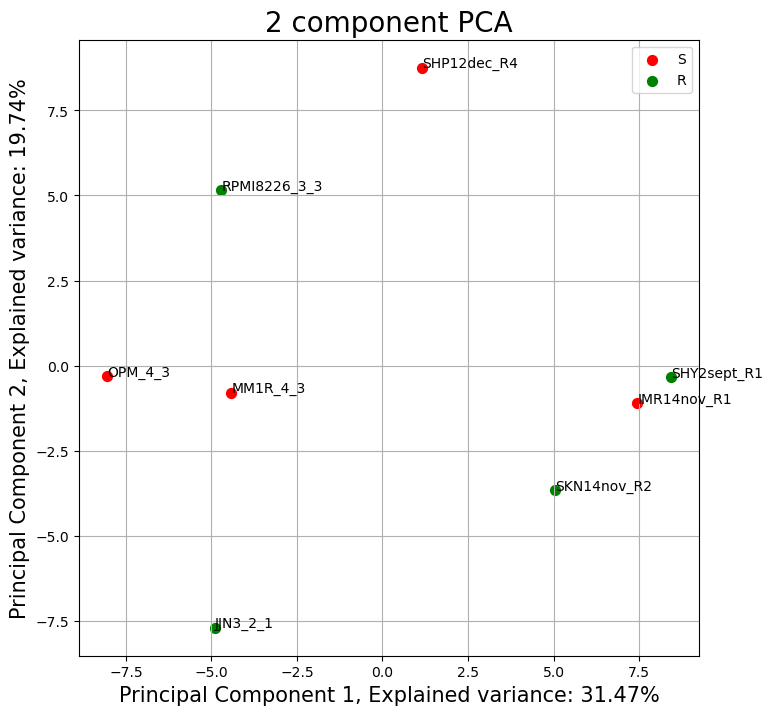

In [211]:
pca_plot(meth_seg_promotors_fm, n_components=2, group_column="Group", label_column = "sample_id_adj")

#### Gene Bodies

In [212]:
cpg_genebds_df = pd.read_csv("/data/lvisser/feature_matrices/concatenated_tables/all_samples/cpg_cat_all_unicvg.csv")
print(cpg_genebds_df.shape)
cpg_genebds_df.head()

(105555914, 6)


,chrom,ref_position,source_directory,sample_id_adj,cpg_coverage,mod_qual
0,chr15,17024844,data_OHMX20230016R_20231114,IMR14nov_R1,1,0.038086
1,chr15,17024908,data_OHMX20230016R_20231114,IMR14nov_R1,2,0.989258
2,chr15,17024909,data_OHMX20230016R_20231114,IMR14nov_R1,1,0.018555
3,chr15,17024994,data_OHMX20230016R_20231114,IMR14nov_R1,10,0.306250
4,chr15,17024995,data_OHMX20230016R_20231114,IMR14nov_R1,4,0.244141


In [213]:
gene_bodies_DEG = pd.read_csv("/data/lvisser/segmentations/gene_bodies_DEG.csv")
meth_seg_genebds = cpg2segment_aggregation_trees(cpg_genebds_df, gene_bodies_DEG[["chrom", "start", "end", "segment_id", "gene_symbol", "length"]].copy())
meth_seg_genebds.to_csv("/data/lvisser/feature_matrices/meth_seg_genebds.csv", index = False)

initializing meth_seg...


Aggregating: 100%|██████████| 200/200 [1:27:36<00:00, 26.28s/it]


In [214]:
meth_seg_genebds = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_genebds.csv")
meth_seg_genebds['positions'] = meth_seg_genebds['positions'].apply(ast.literal_eval)
meth_seg_genebds['mod_qual_positions'] = meth_seg_genebds['mod_qual_positions'].apply(ast.literal_eval)
print(meth_seg_genebds.shape)
meth_seg_genebds.head()

(55400, 11)


,sample_id_adj,segment_id,source_directory,total_methylation,positions,mod_qual_positions,num_cpgs,avg_methylation,gene_symbol,length,chrom
0,RPMI8226_3_3,chr10:100150094-100186033,data_OHMX20230016R_MM_2,243.810195,"[100152160, 100153786, 100153977, 100154106, 1...","[0.99121094, 0.99316406, 0.9892578, 0.99804687...",347,0.702623,ERLIN1,35939,chr10
1,MM1R_4_3,chr10:100150094-100186033,data_OHMX20230016R_MM_2,227.587316,"[100150199, 100152159, 100152255, 100152337, 1...","[0.50097656, 0.9873047, 0.98535156, 0.9560547,...",347,0.655871,ERLIN1,35939,chr10
2,JJN3_2_1,chr10:100150094-100186033,data_OHMX20230016R_MM_2,226.628349,"[100150199, 100152159, 100152160, 100152255, 1...","[0.99414063, 0.92382813, 0.9970703, 0.99902344...",348,0.651231,ERLIN1,35939,chr10
3,OPM_4_3,chr10:100150094-100186033,data_OHMX20230016R_MM_2,206.540227,"[100150199, 100152159, 100152160, 100152255, 1...","[0.765625, 0.036132813, 0.9970703, 0.9970703, ...",326,0.633559,ERLIN1,35939,chr10
4,SHY2sept_R1,chr10:100150094-100186033,data_OHMX20230016R_20231114,259.441940,"[100150199, 100152159, 100152160, 100152255, 1...","[0.94042968, 0.99804687, 0.9970703066666666, 0...",371,0.699304,ERLIN1,35939,chr10


In [215]:
meth_seg_genebds_fm = create_fm(meth_seg_genebds, metadata)
meth_seg_genebds_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_genebds_fm.csv", index = False)

In [216]:
meth_seg_genebds_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_genebds_fm.csv")
print(meth_seg_genebds_fm.shape)
meth_seg_genebds_fm.head()

(8, 6672)


,Group,sample_id_adj,source_directory,chr10:100150094-100186033,chr10:100232298-100267680,chr10:100273280-100286680,chr10:100347233-100364826,chr10:100463009-100483744,chr10:100735396-100829944,chr10:100969518-100985871,...,chrX:8528874-8732137,chrX:87517409-87670050,chrX:89921908-89922883,chrX:91434595-91438584,chrX:91779261-92623230,chrX:93674013-93712274,chrX:9463320-9741037,chrX:9725346-9786297,chrX:9786429-9949443,tumor_type
0,S,IMR14nov_R1,data_OHMX20230016R_20231114,0.654308,0.919633,0.778300,0.679719,0.441944,0.473404,0.895362,...,0.711954,0.504883,0.988281,0.761475,0.931853,0.970672,0.900731,0.939126,0.941955,NB
1,S,SHP12dec_R4,data_OHMX20230016R_20231114,0.680587,0.928848,0.873169,0.652430,0.426032,0.439927,0.900292,...,0.311011,0.042969,0.045898,0.392643,0.211329,0.477329,0.592505,0.730360,0.787372,NB
2,R,SHY2sept_R1,data_OHMX20230016R_20231114,0.699304,0.909993,0.744086,0.642068,0.605702,0.440883,0.915816,...,0.511585,0.050781,0.030273,0.357178,0.224058,0.322418,0.677907,0.647684,0.589921,NB
3,R,SKN14nov_R2,data_OHMX20230016R_20231114,0.690636,0.881976,0.745776,0.606008,0.367547,0.391530,0.833200,...,0.294577,0.041992,0.033203,0.260742,0.389987,0.735502,0.907118,0.668937,0.385445,NB
4,R,JJN3_2_1,data_OHMX20230016R_MM_2,0.651231,0.840759,0.765911,0.595766,0.261928,0.252834,0.675543,...,0.268507,0.996094,0.032227,0.387695,0.398054,0.464374,0.781714,0.493714,0.545954,MM


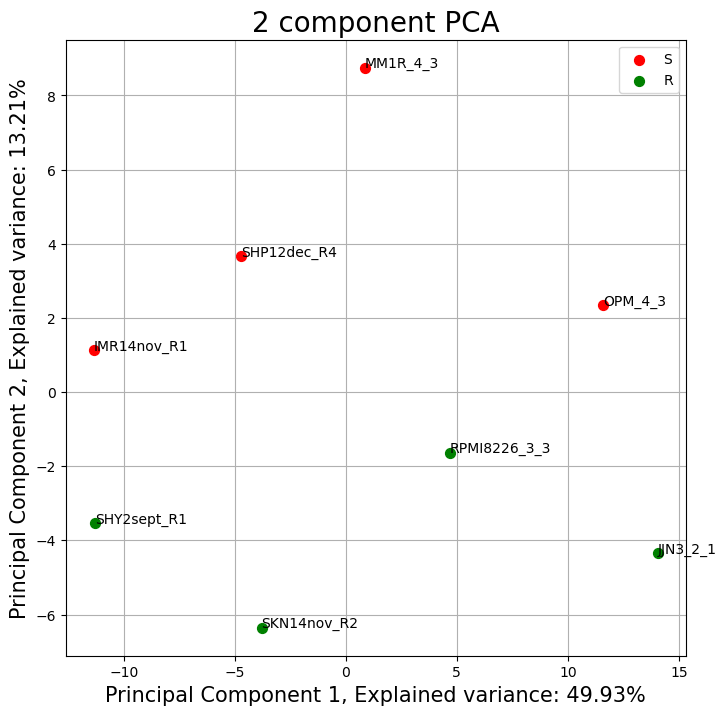

In [217]:
pca_plot(meth_seg_genebds_fm, n_components=2, group_column="Group", label_column = "sample_id_adj")

#### Correlation Transcription-Methylation

In [218]:
correlations_promotors_df = tm_pcc(meth_seg_promotors, metadata, DEG_full, "/data/lvisser/tm_pcc/tm_pcc_promotors.csv")
print(correlations_promotors_df.shape)
correlations_promotors_df.head()

Average methylation - log2counts pearson correlation: -0.10262929365735148
p-value: 1.295125592601539e-61
Total methylation - log2counts pearson correlation: 0.07552819292203214
p-value: 4.2622573240109e-34
(4293, 3)


,gene_symbol,correlation,p_value
1564,SERPINB7,0.999741,0.000005
1102,ARPIN,0.998711,0.000056
4164,MPDZ,0.998566,0.000065
3167,ANXA5,-0.998158,0.000095
390,TRIM22,0.997998,0.000108


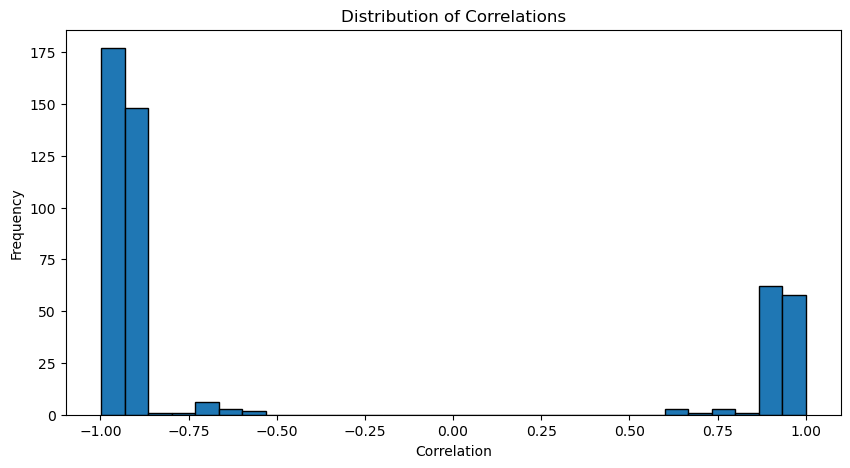

In [219]:
# Call the function with your correlations DataFrame
plot_correlation_distribution(correlations_promotors_df[correlations_promotors_df["p_value"] < 0.05])

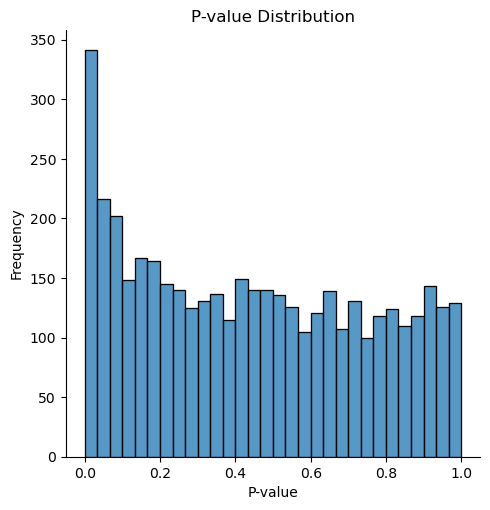

In [220]:
plot_pvalue_distribution(correlations_promotors_df["p_value"])

In [221]:
correlations_genebds_df = tm_pcc(meth_seg_genebds, metadata, DEG_full, "/data/lvisser/tm_pcc/tm_pcc_genebds.csv")
print(correlations_genebds_df.shape)
correlations_genebds_df.head()

Average methylation - log2counts pearson correlation: 0.3741393229992128
p-value: 0.0
Total methylation - log2counts pearson correlation: 0.26172801653965033
p-value: 0.0
(6619, 3)


,gene_symbol,correlation,p_value
589,HBD,1.000000,0.000000e+00
1466,CXADRP2,0.999923,8.059755e-07
6481,IFNE,0.999846,2.294561e-06
2949,LINC01772,0.999227,2.579180e-05
112,BEND7,0.999151,2.968308e-05


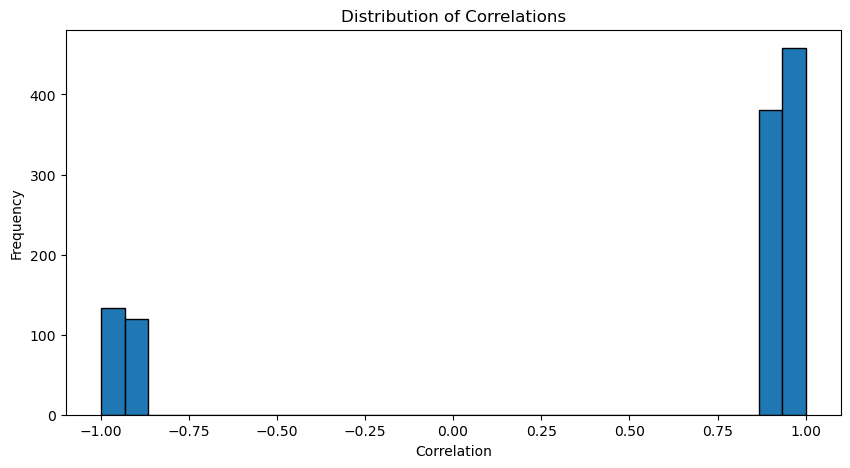

In [222]:
# Call the function with your correlations DataFrame
plot_correlation_distribution(correlations_genebds_df[correlations_genebds_df["p_value"] < 0.05])

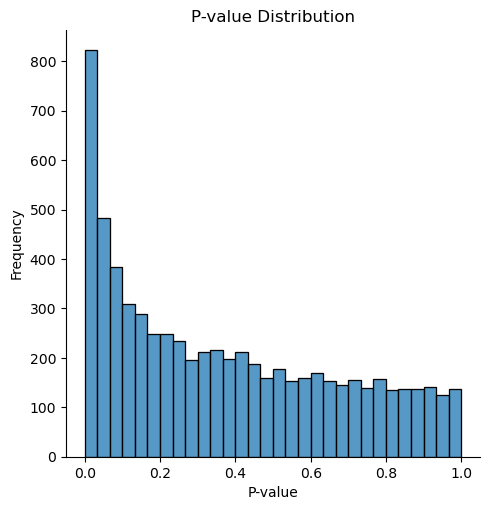

In [223]:
plot_pvalue_distribution(correlations_genebds_df["p_value"])

## Model Training

### Promotor Regions

In [94]:
meth_seg_promotors_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_promotors_fm.csv")
print(meth_seg_promotors_fm.shape)
meth_seg_promotors_fm.head()

(8, 4745)


,Group,sample_id_adj,source_directory,chr10:100007200-100011200,chr10:100183600-100187801,chr10:100266000-100268800,chr10:100284600-100287601,chr10:100345600-100351401,chr10:100745000-100746201,chr10:100968800-100972001,...,chrX:81119601-81122600,chrX:85002601-85005201,chrX:85375201-85380000,chrX:8729800-8732801,chrX:91434001-91436601,chrX:9462800-9468201,chrX:9764801-9766201,chrX:9785000-9788401,chrX:9912200-9915000,tumor_type
0,S,IMR14nov_R1,data_OHMX20230016R_20231114,0.290123,0.286979,0.669037,0.484533,0.217334,0.221267,0.221540,...,0.119683,0.131966,0.0,0.290820,0.761475,0.130469,0.942758,0.840195,0.902930,NB
1,S,SHP12dec_R4,data_OHMX20230016R_20231114,0.210844,0.279630,0.837943,0.555257,0.217633,0.805809,0.664258,...,0.038379,0.397461,0.0,0.539388,0.392643,0.422164,0.850849,0.714821,0.320457,NB
2,R,SHY2sept_R1,data_OHMX20230016R_20231114,0.312590,0.297658,0.785635,0.537883,0.248456,0.271168,0.292039,...,0.034686,0.200439,0.0,0.239757,0.357178,0.140259,0.424845,0.684925,0.363281,NB
3,R,SKN14nov_R2,data_OHMX20230016R_20231114,0.409756,0.194222,0.645020,0.392968,0.199697,0.241347,0.252734,...,0.038737,0.087416,0.0,0.206008,0.260742,0.141866,0.819221,0.630834,0.048828,NB
4,R,JJN3_2_1,data_OHMX20230016R_MM_2,0.316730,0.212823,0.528454,0.515598,0.216315,0.219263,0.316882,...,0.035156,0.145278,0.0,0.412621,0.387695,0.314923,0.684226,0.313171,0.388672,MM


In [95]:
meth_seg_promotors_nb1_fm = meth_seg_promotors_fm[meth_seg_promotors_fm["tumor_type"] == "NB"]
meth_seg_promotors_mm1_fm = meth_seg_promotors_fm[meth_seg_promotors_fm["tumor_type"] == "MM"]

#### NB

Regularization has removed 4401 features of the original 4741.
Sample: 0
Cell line: SKN14nov_R2
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.6476770458906427
['S']: 0.35232295410935727

PCA after filtering:


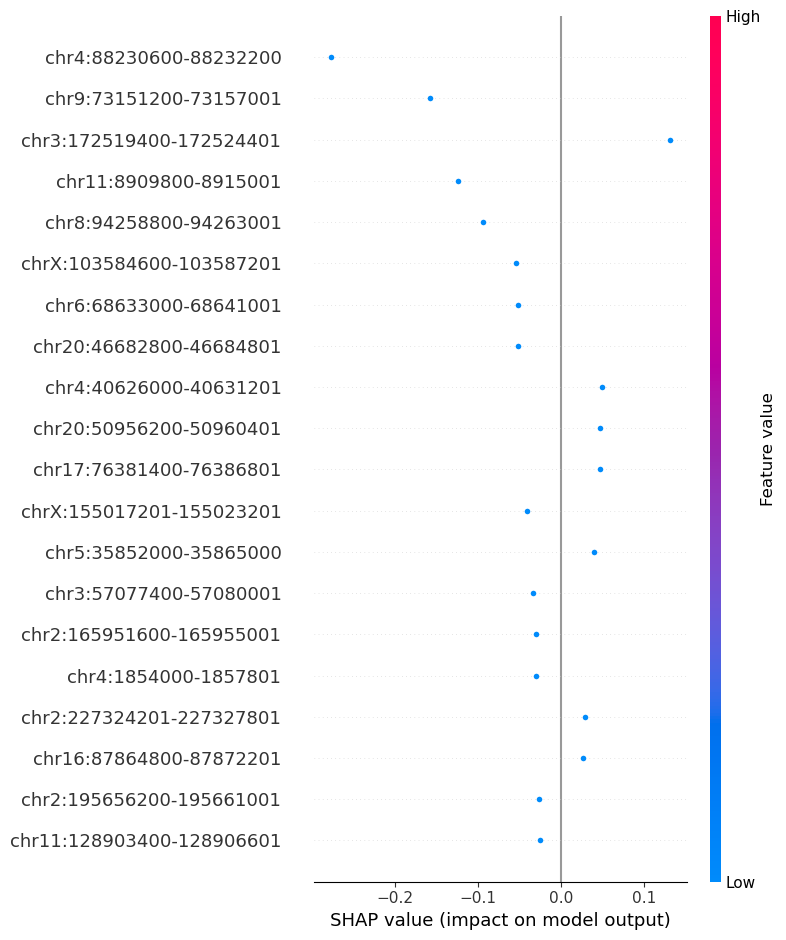

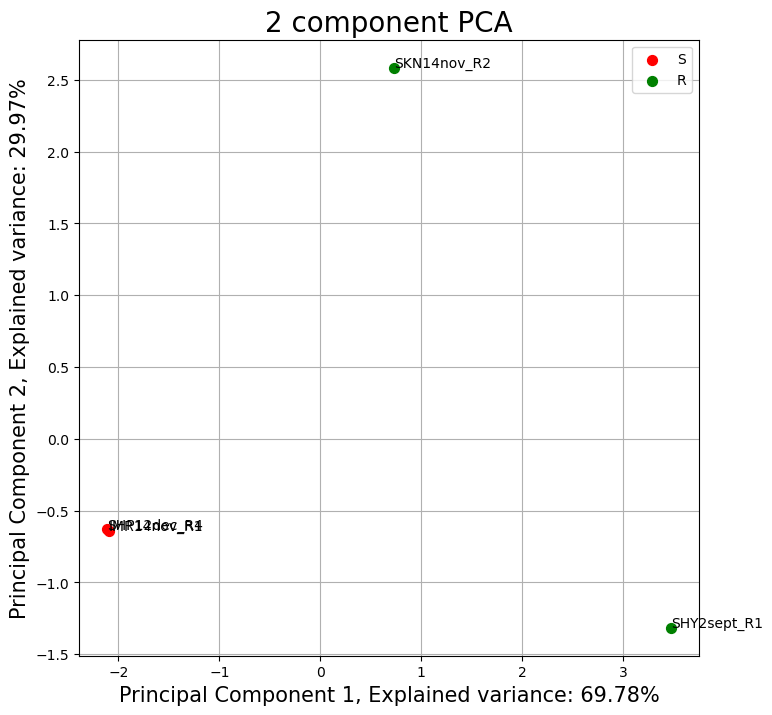

In [107]:
train_indices = [0, 1, 2]
test_indices = [3]
name = "promotors_nb1"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_promotors_nb1_fm, train_indices = train_indices, test_indices = test_indices, reg = True)
save_model(model, train_indices, test_indices, name)

In [108]:
ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:],
    feature_names=X_test.columns
)

In [100]:
shap_promotors_nb1_df = train_and_predict_loo(meth_seg_promotors_nb1_fm, reg = True)
shap_promotors_nb1_df_annot = find_annot_overlap(shap_promotors_nb1_df, rf_promotors_genes)
shap_promotors_nb1_df_annot.to_csv("/data/lvisser/shap/shap_promotors_nb1_df_annot.csv", index=False)

Average accuracy: 0.75


In [101]:
shap_promotors_nb1_df = pd.read_csv("/data/lvisser/shap/shap_promotors_nb1_df_annot.csv")
print(shap_promotors_nb1_df_annot.shape)
shap_promotors_nb1_df_annot.head()

(1306, 10)


,segment_id,average_shap_value,reliability_shap_value,shap_variance,z_score,avg_meth_R,avg_meth_S,diff,direction,gene_symbol
0,chr9:14530400-14532201,0.499987,0.499987,0.752243,31.065487,0.995117,0.495117,0.500000,M,NFIB
1,chr7:23104601-23109001,0.180124,0.180124,0.098489,11.150552,0.263320,0.286609,-0.023289,U,FAM126A
2,chr11:118262200-118266401,0.087783,0.087783,0.023492,5.401310,0.045898,0.203451,-0.157552,U,MPZL2
3,chr4:88230600-88232200,-0.068259,0.068259,0.014458,4.185783,0.504980,0.992839,-0.487858,U,ABCG2
4,chr7:124761600-124766800,0.068195,0.068195,0.014237,4.181779,0.248058,0.456199,-0.208141,U,GPR37


#### MM

Regularization has removed 4314 features of the original 4741.
Sample: 0
Cell line: RPMI8226_3_3
True label: R (0)
Predicted label: S (1)
Probabilities:
['R']: 0.24689505299781045
['S']: 0.7531049470021896

PCA after filtering:


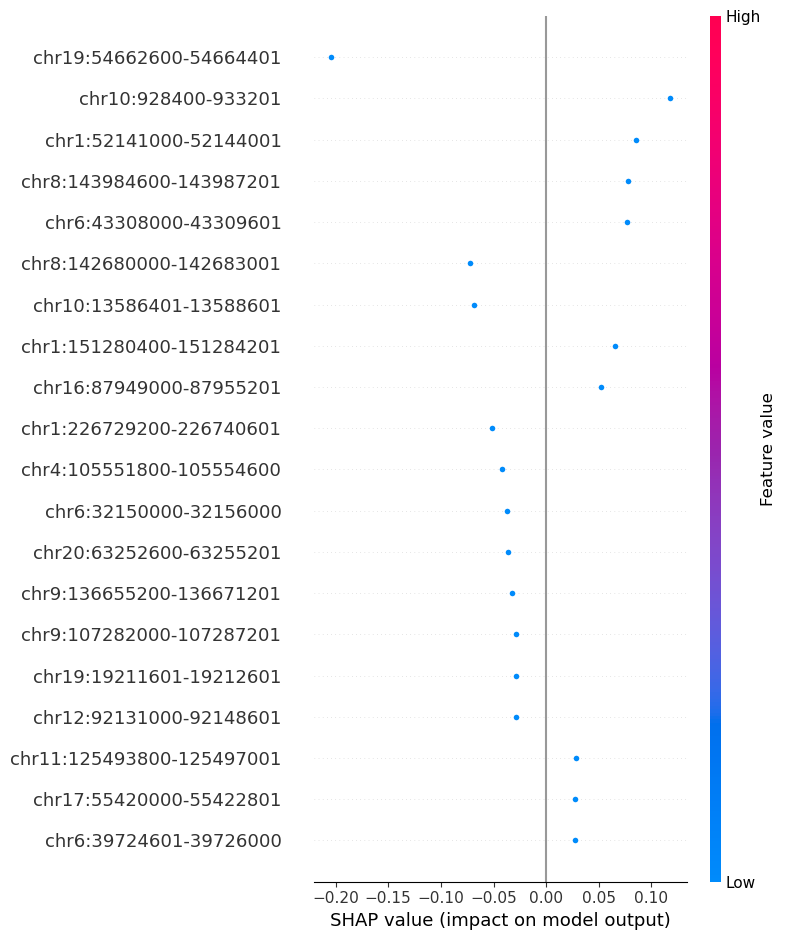

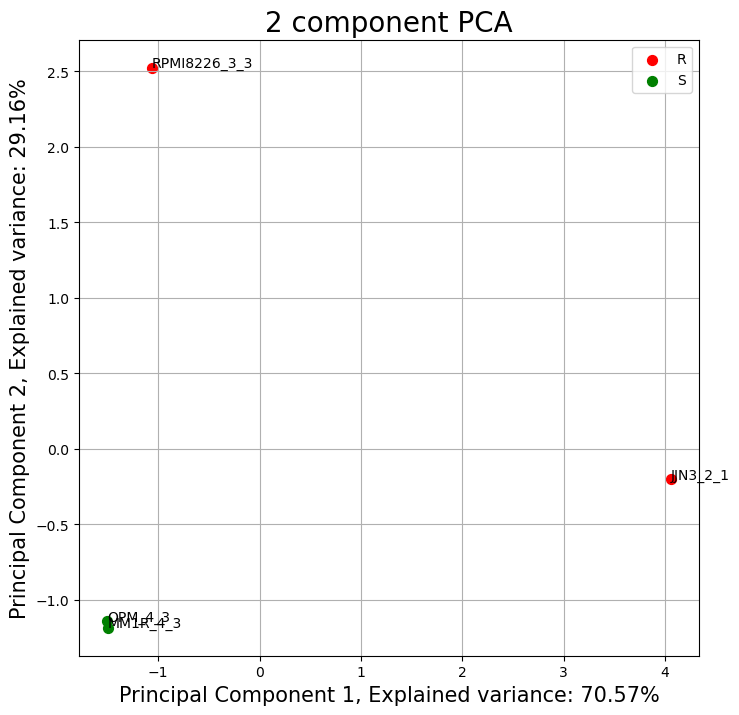

In [109]:
train_indices = [0, 1, 2]
test_indices = [3]
name = "promotors_mm1"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_promotors_mm1_fm, train_indices = train_indices, test_indices = test_indices, reg = True)
save_model(model, train_indices, test_indices, name)

In [110]:
ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:],
    feature_names=X_test.columns
)

In [111]:
shap_promotors_mm1_df = train_and_predict_loo(meth_seg_promotors_mm1_fm, reg = True)
shap_promotors_mm1_df_annot = find_annot_overlap(shap_promotors_mm1_df, rf_promotors_genes)
shap_promotors_mm1_df_annot.to_csv("/data/lvisser/shap/shap_promotors_mm1_df_annot.csv", index=False)

Average accuracy: 0.25


In [112]:
shap_promotors_mm1_df_annot = pd.read_csv("/data/lvisser/shap/shap_promotors_mm1_df_annot.csv")
print(shap_promotors_mm1_df_annot.shape)
shap_promotors_mm1_df_annot.head()

(1107, 10)


,segment_id,average_shap_value,reliability_shap_value,shap_variance,z_score,avg_meth_R,avg_meth_S,diff,direction,gene_symbol
0,chr18:63777600-63778801,0.714806,0.714806,1.538969,9.540004,0.012695,0.447266,-0.434570,U,SERPINB7
1,chr11:5688800-5692801,0.297718,0.297718,0.268417,3.985060,0.000000,0.502930,-0.502930,U,TRIM22
2,chr12:54979800-54986001,0.062672,0.062672,0.012252,0.854615,0.000000,0.522461,-0.522461,U,TESPA1
3,chr19:54662600-54664401,-0.050443,0.050443,0.007908,0.691748,0.524414,0.000000,0.524414,M,LILRB4
4,chr15:26866601-26868201,-0.046200,0.046200,0.006686,0.635233,0.552246,0.994141,-0.441895,U,GABRA5


### Gene Bodies

In [113]:
meth_seg_genebds_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_genebds_fm.csv")
print(meth_seg_genebds_fm.shape)
meth_seg_genebds_fm.head()

(8, 6672)


,Group,sample_id_adj,source_directory,chr10:100150094-100186033,chr10:100232298-100267680,chr10:100273280-100286680,chr10:100347233-100364826,chr10:100463009-100483744,chr10:100735396-100829944,chr10:100969518-100985871,...,chrX:8528874-8732137,chrX:87517409-87670050,chrX:89921908-89922883,chrX:91434595-91438584,chrX:91779261-92623230,chrX:93674013-93712274,chrX:9463320-9741037,chrX:9725346-9786297,chrX:9786429-9949443,tumor_type
0,S,IMR14nov_R1,data_OHMX20230016R_20231114,0.654308,0.919633,0.778300,0.679719,0.441944,0.473404,0.895362,...,0.711954,0.504883,0.988281,0.761475,0.931853,0.970672,0.900731,0.939126,0.941955,NB
1,S,SHP12dec_R4,data_OHMX20230016R_20231114,0.680587,0.928848,0.873169,0.652430,0.426032,0.439927,0.900292,...,0.311011,0.042969,0.045898,0.392643,0.211329,0.477329,0.592505,0.730360,0.787372,NB
2,R,SHY2sept_R1,data_OHMX20230016R_20231114,0.699304,0.909993,0.744086,0.642068,0.605702,0.440883,0.915816,...,0.511585,0.050781,0.030273,0.357178,0.224058,0.322418,0.677907,0.647684,0.589921,NB
3,R,SKN14nov_R2,data_OHMX20230016R_20231114,0.690636,0.881976,0.745776,0.606008,0.367547,0.391530,0.833200,...,0.294577,0.041992,0.033203,0.260742,0.389987,0.735502,0.907118,0.668937,0.385445,NB
4,R,JJN3_2_1,data_OHMX20230016R_MM_2,0.651231,0.840759,0.765911,0.595766,0.261928,0.252834,0.675543,...,0.268507,0.996094,0.032227,0.387695,0.398054,0.464374,0.781714,0.493714,0.545954,MM


In [114]:
meth_seg_genebds_nb1_fm = meth_seg_genebds_fm[meth_seg_genebds_fm["tumor_type"] == "NB"]
meth_seg_genebds_mm1_fm = meth_seg_genebds_fm[meth_seg_genebds_fm["tumor_type"] == "MM"]

#### NB

Regularization has removed 6147 features of the original 6668.
Sample: 0
Cell line: SKN14nov_R2
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.8869720450333145
['S']: 0.11302795496668552

PCA after filtering:


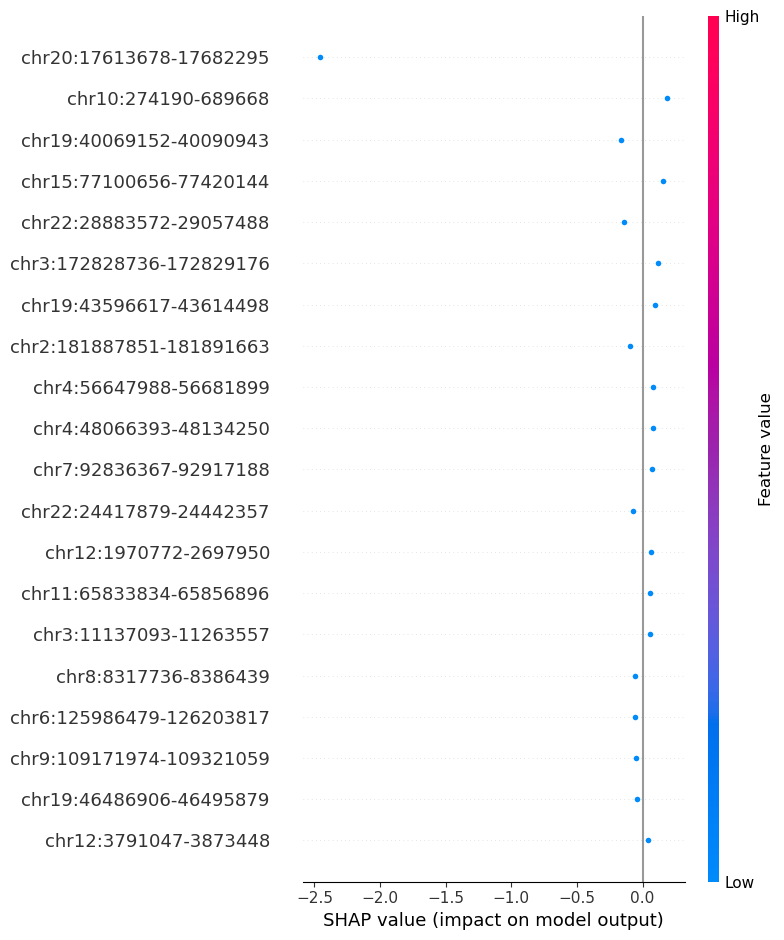

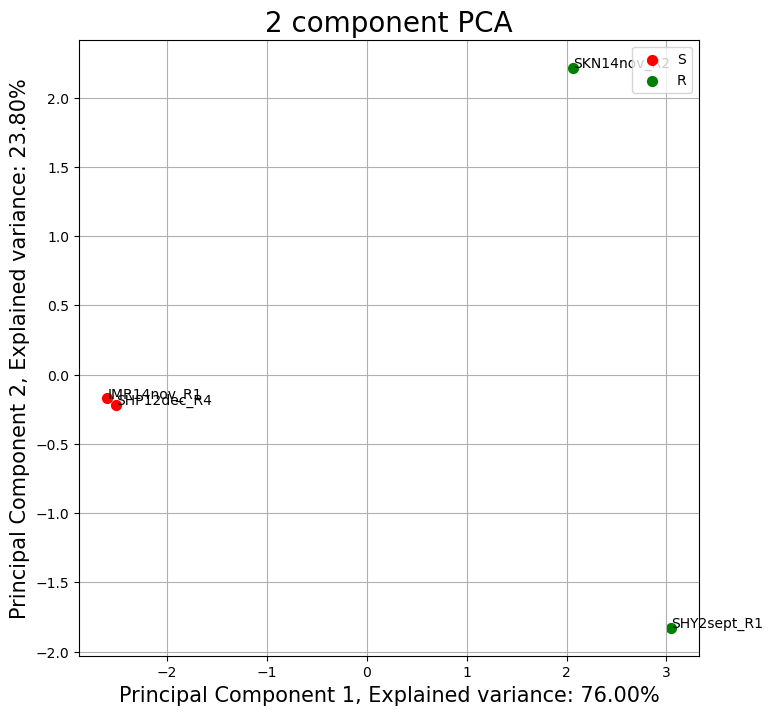

In [116]:
train_indices = [0, 1, 2]
test_indices = [3]
name = "genebds_nb1"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_genebds_nb1_fm, train_indices = train_indices, test_indices = test_indices, reg = True)
save_model(model, train_indices, test_indices, name)

In [117]:
ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:],
    feature_names=X_test.columns
)

In [118]:
shap_genebds_nb1_df = train_and_predict_loo(meth_seg_genebds_nb1_fm, reg = True)
shap_genebds_nb1_df_annot = find_annot_overlap(shap_genebds_nb1_df, gene_bodies_105)
shap_genebds_nb1_df_annot.to_csv("/data/lvisser/shap/shap_genebds_nb1_df_annot.csv", index=False)

Average accuracy: 0.5


In [119]:
shap_genebds_nb1_df_annot = pd.read_csv("/data/lvisser/shap/shap_genebds_nb1_df_annot.csv")
print(shap_genebds_nb1_df_annot.shape)
shap_genebds_nb1_df_annot.head()

(1677, 10)


,segment_id,average_shap_value,reliability_shap_value,shap_variance,z_score,avg_meth_R,avg_meth_S,diff,direction,gene_symbol
0,chr20:17613678-17682295,-0.614111,0.614111,1.133737,38.431107,0.788625,0.823618,-0.034993,U,RRBP1
1,chr6:112616703-112617880,0.089407,0.089407,0.024406,5.575247,0.995605,0.520386,0.475220,M,PA2G4P5
2,chr1:208606564-208614295,0.073510,0.073510,0.016569,4.579794,0.994039,0.634434,0.359604,M,LINC01735
3,chr19:40069152-40090943,-0.040494,0.040494,0.005052,2.512388,0.906782,0.953221,-0.046440,U,ZNF780A
4,chr22:28883572-29057488,-0.035846,0.035846,0.003970,2.221386,0.848564,0.865944,-0.017379,U,ZNRF3


#### MM

Regularization has removed 6246 features of the original 6668.
Sample: 0
Cell line: RPMI8226_3_3
True label: R (0)
Predicted label: S (1)
Probabilities:
['R']: 0.17485301050969249
['S']: 0.8251469894903075

PCA after filtering:


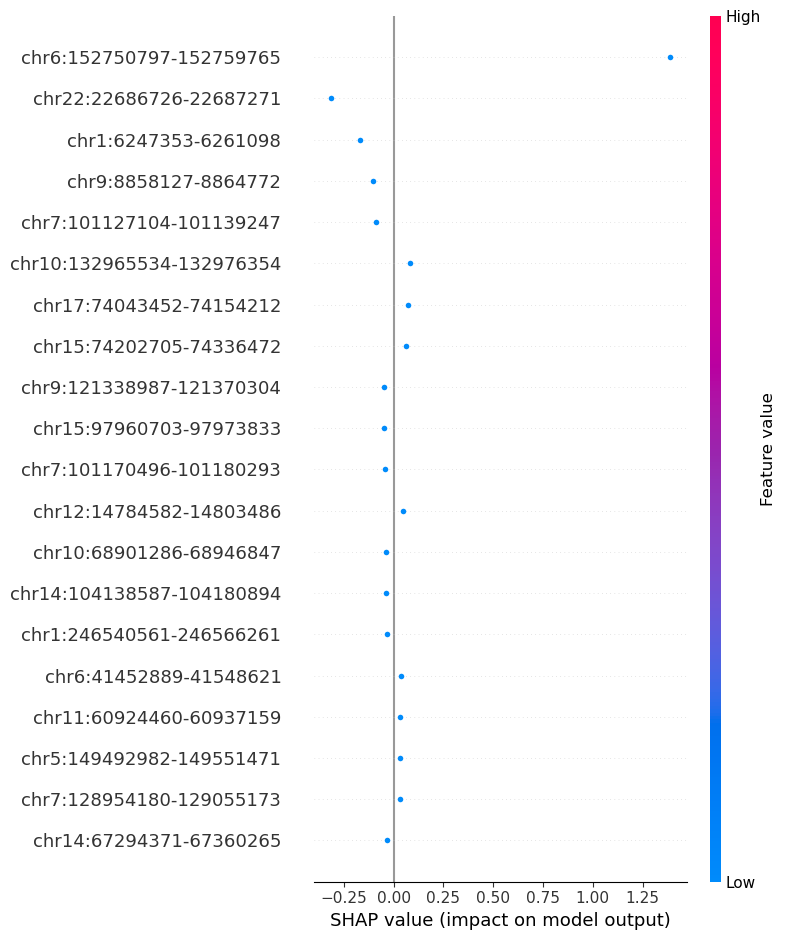

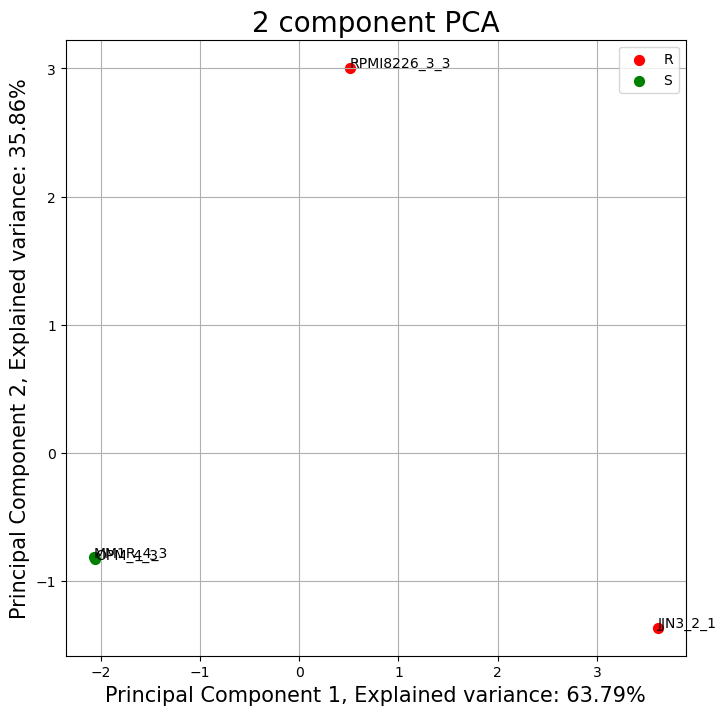

In [120]:
train_indices = [0, 1, 2]
test_indices = [3]
name = "genebds_mm1"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_genebds_mm1_fm, train_indices = train_indices, test_indices = test_indices, reg = True)
save_model(model, train_indices, test_indices, name)

In [121]:
ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:],
    feature_names=X_test.columns
)

In [122]:
shap_genebds_mm1_df = train_and_predict_loo(meth_seg_genebds_mm1_fm, reg = True)
shap_genebds_mm1_df_annot = find_annot_overlap(shap_genebds_mm1_df, gene_bodies_105)
shap_genebds_mm1_df_annot.to_csv("/data/lvisser/shap/shap_genebds_mm1_df_annot.csv", index=False)

Average accuracy: 0.25


In [123]:
shap_genebds_mm1_df_annot = pd.read_csv("/data/lvisser/shap/shap_genebds_mm1_df_annot.csv")
print(shap_genebds_mm1_df_annot.shape)
shap_genebds_mm1_df_annot.head()

(1295, 10)


,segment_id,average_shap_value,reliability_shap_value,shap_variance,z_score,avg_meth_R,avg_meth_S,diff,direction,gene_symbol
0,chr22:22686726-22687271,-0.078093,0.078093,0.018765,7.218163,0.515625,0.000000,0.515625,M,IGLV3-25
1,chr14:35430260-35430631,0.069582,0.069582,0.014880,6.432824,0.000000,0.511719,-0.511719,U,DNAJC8P1
2,chr1:6247353-6261098,-0.041620,0.041620,0.005443,3.852879,0.459717,0.287606,0.172111,M,GPR153
3,chr9:8858127-8864772,-0.024892,0.024892,0.001975,2.309424,0.545898,0.000000,0.545898,M,PTPRD
4,chr4:153780591-153789083,0.023284,0.023284,0.001725,2.161057,0.528349,0.661974,-0.133625,U,SFRP2


### WGBS_tools

#### NB

In [124]:
print(meth_seg_wgbs_nb1_fm.shape)
meth_seg_wgbs_nb1_fm.head()

(4, 1546160)


,sample_id_adj,chr22:10510235-10512049,chr22:10513853-10515736,chr22:10516017-10517750,chr22:10518304-10520219,chr22:10522965-10524772,chr22:10525487-10525747,chr22:10525749-10525908,chr22:10525917-10525931,chr22:10525943-10526051,...,chr9:138243659-138245623,chr9:138256043-138257768,chr9:138258705-138260224,chr9:138301800-138302861,chr9:138303904-138304191,chr9:138314410-138315821,chr9:138316464-138318349,source_directory,Group,tumor_type
0,IMR14nov_R1,0.88,0.92,1.00,1.00,1.00,1.00,0.97,1.00,0.89,...,0.95,0.67,0.84,1.00,1.00,0.85,0.14,data_OHMX20230016R_20231114,S,NB
1,SHP12dec_R4,0.04,0.02,0.15,0.00,0.04,0.84,0.96,0.89,0.91,...,0.00,0.00,0.00,0.25,0.86,0.09,0.00,data_OHMX20230016R_20231114,S,NB
2,SHY2sept_R1,0.04,0.08,0.00,0.00,0.00,0.81,0.56,0.34,0.62,...,0.88,1.00,1.00,0.80,0.93,1.00,1.00,data_OHMX20230016R_20231114,R,NB
3,SKN14nov_R2,0.06,0.07,0.00,0.09,0.02,0.71,0.59,0.17,0.74,...,0.37,0.00,0.16,0.23,0.40,0.33,0.11,data_OHMX20230016R_20231114,R,NB


DMR has removed 1459973 features of the original 1546156.
Regularization has removed 23259 features of the original 86183.
Sample: 0
Cell line: SKN14nov_R2
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.8001135550180108
['S']: 0.19988644498198913

PCA after filtering:


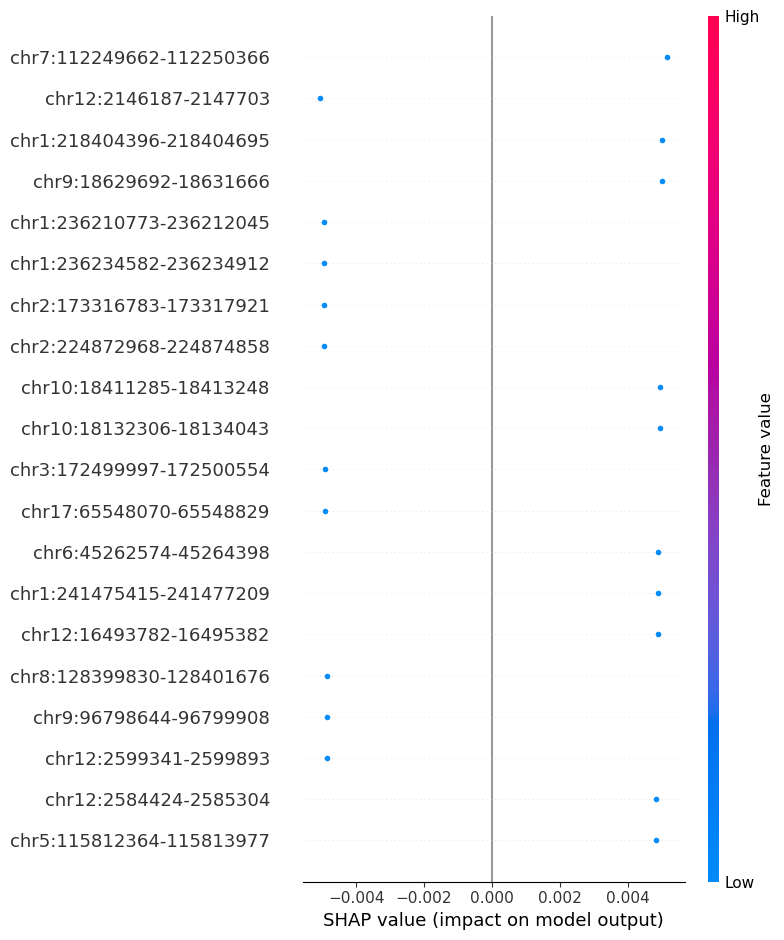

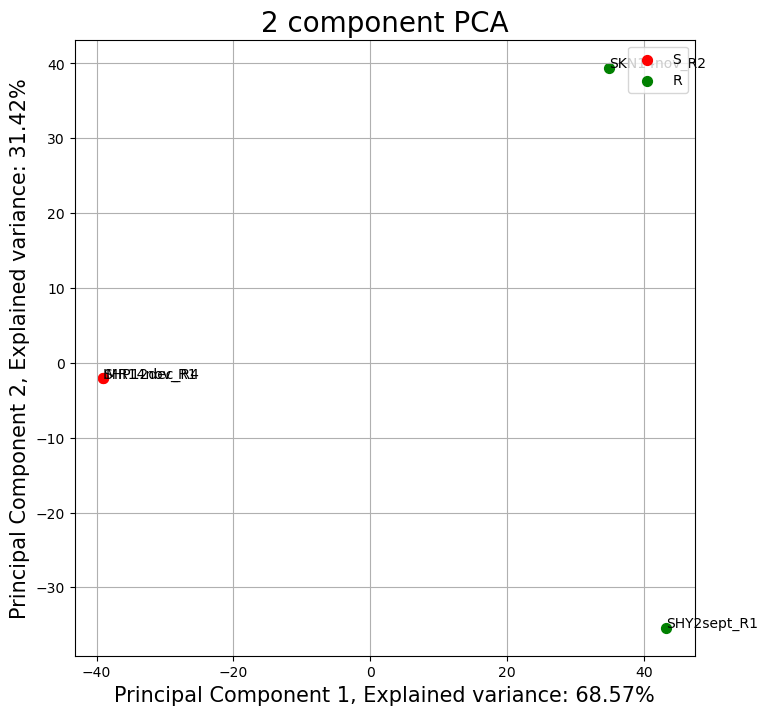

In [125]:
train_indices = [0, 1, 2]
test_indices = [3]
name = "wgbs_nb1"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_wgbs_nb1_fm, train_indices = train_indices, test_indices = test_indices, reg = True, dmr = "ttest")
save_model(model, train_indices, test_indices, name)

In [48]:
shap_wgbs_nb1_df = train_and_predict_loo(meth_seg_wgbs_nb1_fm, reg = True, dmr = "ttest")
shap_wgbs_nb1_df_annot = find_annot_overlap(shap_wgbs_nb1_df, rf_promotors_genes)
shap_wgbs_nb1_df_annot.to_csv("/data/lvisser/shap/shap_wgbs_nb1_df_annot.csv", index=False)

Average accuracy: 1.0


In [49]:
shap_wgbs_nb1_df_annot = pd.read_csv("/data/lvisser/shap/shap_wgbs_nb1_df_annot.csv")
print(shap_wgbs_nb1_df_annot.shape)
shap_wgbs_nb1_df_annot.head()

(220646, 9)


,segment_id,average_shap_value,reliability_shap_value,z_score,avg_meth_R,avg_meth_S,diff,direction,gene_symbol
0,chr12:2146187-2147703,-0.001264,0.001264,14.289378,0.47,0.94,-0.47,U,NaN
1,chr1:236210773-236212045,-0.001237,0.001237,13.978825,0.52,0.98,-0.46,U,NaN
2,chr1:236234582-236234912,-0.001237,0.001237,13.978825,0.48,0.94,-0.46,U,NaN
3,chr2:173316783-173317921,-0.001237,0.001237,13.978825,0.51,0.97,-0.46,U,NaN
4,chr2:224872968-224874858,-0.001237,0.001237,13.978825,0.49,0.95,-0.46,U,NaN


#### MM

In [126]:
print(meth_seg_wgbs_mm1_fm.shape)
meth_seg_wgbs_mm1_fm.head()

(4, 1640061)


,sample_id_adj,chr22:10519035-10520844,chr22:10523473-10525269,chr22:10525487-10525946,chr22:10525988-10526067,chr22:10526102-10526125,chr22:10526140-10526194,chr22:10526196-10526215,chr22:10526238-10526899,chr22:10526908-10528747,...,chr9:138230113-138231335,chr9:138231458-138231709,chr9:138231832-138232715,chr9:138232777-138234470,chr9:138234559-138235402,chr9:138235579-138237577,chr9:138258705-138259649,source_directory,Group,tumor_type
0,JJN3_2_1,0.04,0.25,0.71,0.48,0.24,0.68,0.27,0.66,0.79,...,0.00,0.16,0.01,0.10,0.08,0.11,0.27,data_OHMX20230016R_MM_2,R,MM
1,MM1R_4_3,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.98,0.98,...,0.00,0.40,0.59,0.45,0.08,0.53,0.38,data_OHMX20230016R_MM_2,S,MM
2,OPM_4_3,0.00,0.30,0.58,1.00,0.25,0.78,0.12,0.46,0.44,...,0.02,0.50,0.44,0.32,0.27,0.14,0.00,data_OHMX20230016R_MM_2,S,MM
3,RPMI8226_3_3,1.00,1.00,1.00,0.97,1.00,0.90,1.00,0.98,0.99,...,0.03,0.29,0.19,0.07,0.09,0.20,0.00,data_OHMX20230016R_MM_2,R,MM


DMR has removed 1557280 features of the original 1640057.
Regularization has removed 26447 features of the original 82777.
Sample: 0
Cell line: RPMI8226_3_3
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.9455317359811551
['S']: 0.05446826401884489

PCA after filtering:


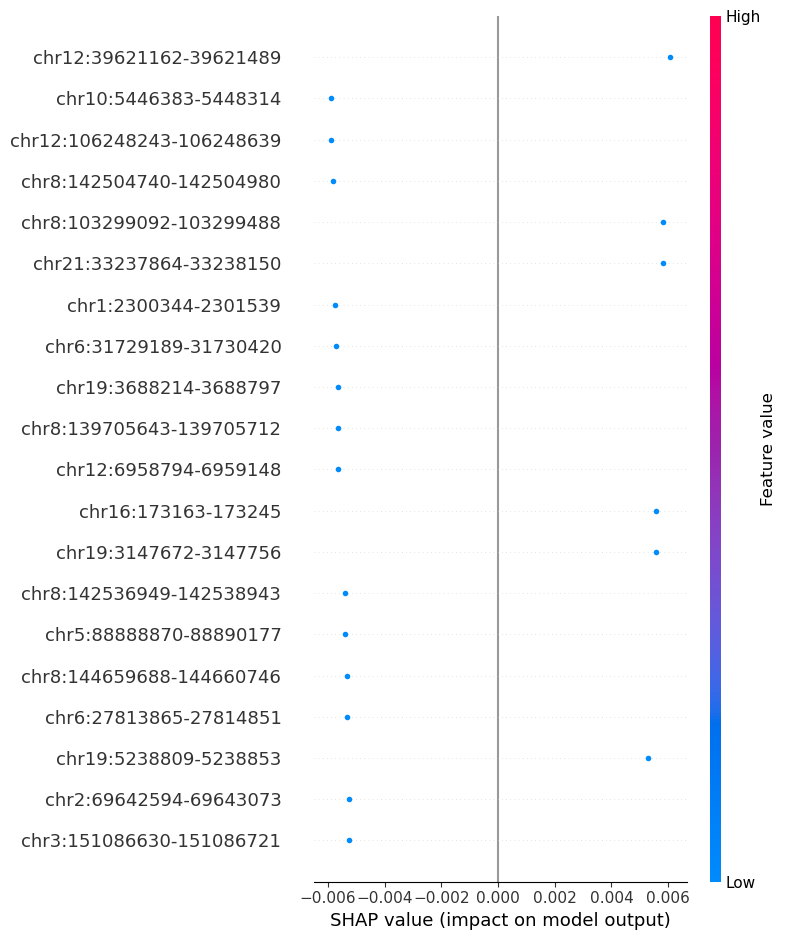

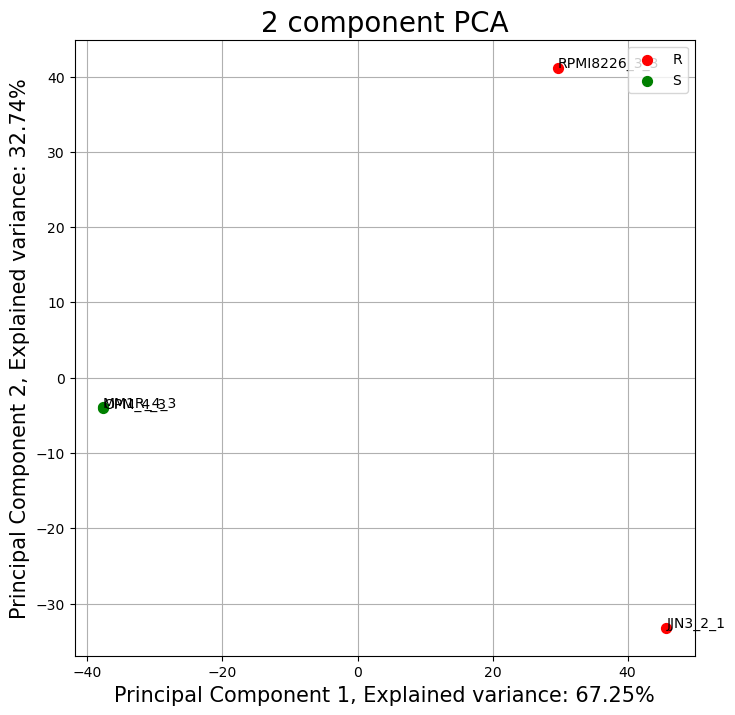

In [127]:
train_indices = [0, 1, 2]
test_indices = [3]
name = "wgbs_mm1"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_wgbs_mm1_fm, train_indices = train_indices, test_indices = test_indices, reg = True, dmr = "ttest")
save_model(model, train_indices, test_indices, name)

In [50]:
shap_wgbs_mm1_df = train_and_predict_loo(meth_seg_wgbs_mm1_fm, reg = True, dmr = "ttest")
shap_wgbs_mm1_df_annot = find_annot_overlap(shap_wgbs_mm1_df, rf_promotors_genes)
shap_wgbs_mm1_df_annot.to_csv("/data/lvisser/shap/shap_wgbs_mm1_df_annot.csv", index=False)

Average accuracy: 1.0


In [51]:
shap_wgbs_mm1_df_annot = pd.read_csv("/data/lvisser/shap/shap_wgbs_mm1_df_annot.csv")
print(shap_wgbs_mm1_df_annot.shape)
shap_wgbs_mm1_df_annot.head()

(235718, 9)


,segment_id,average_shap_value,reliability_shap_value,z_score,avg_meth_R,avg_meth_S,diff,direction,gene_symbol
0,chr12:106248243-106248639,-0.001467,0.001467,25.262357,0.475,0.0,0.475,M,CKAP4
1,chr10:5446383-5448314,-0.001467,0.001467,25.262357,0.475,0.0,0.475,M,NET1
2,chr8:142504740-142504980,-0.001451,0.001451,24.989752,0.470,0.0,0.470,M,NaN
3,chr1:2300344-2301539,-0.001435,0.001435,24.717147,0.465,0.0,0.465,M,NaN
4,chr6:31729189-31730420,-0.001420,0.001420,24.444544,0.460,0.0,0.460,M,DDAH2


#### Roberto

In [43]:
print(meth_seg_wgbs_rob_fm.shape)
meth_seg_wgbs_rob_fm.head()

(4, 1506198)


,sample_id_adj,chr22:10510235-10512049,chr22:10513853-10515736,chr22:10516385-10518350,chr22:10519035-10520844,chr22:10521531-10523474,chr22:10523565-10525269,chr22:10525487-10525647,chr22:10525675-10525733,chr22:10525744-10525753,...,chr9:138235444-138235580,chr9:138235594-138235838,chr9:138235928-138236338,chr9:138236806-138238555,chr9:138243705-138245697,chr9:138257561-138259442,chr9:138303904-138305610,source_directory,Group,tumor_type
0,SH-SY5Y_C1,0.14,0.04,0.12,0.00,0.04,0.04,0.74,0.81,0.68,...,1.00,0.56,0.94,0.74,0.80,0.90,1.00,data_OHMXroberto,R,NB
1,SH-SY5Y_C2,0.03,0.08,0.00,0.21,0.03,0.08,0.81,0.86,0.57,...,0.90,0.25,0.80,0.83,0.87,0.88,0.97,data_OHMXroberto,R,NB
2,SH-SY5Y_J1,0.03,0.00,0.00,0.05,0.06,0.09,0.80,0.69,0.62,...,1.00,0.45,0.77,0.79,0.96,0.90,0.95,data_OHMXroberto,S,NB
3,SH-SY5Y_J2,0.00,0.00,0.06,0.04,0.00,0.15,0.75,0.75,0.86,...,0.94,0.14,1.00,0.92,0.94,0.93,0.96,data_OHMXroberto,S,NB


DMR has removed 1388098 features of the original 1506194.
Regularization has removed 16410 features of the original 118096.
Sample: 0
Cell line: SH-SY5Y_J2
True label: S (1)
Predicted label: S (1)
Probabilities:
['R']: 0.39198983035074486
['S']: 0.6080101696492551

PCA after filtering:


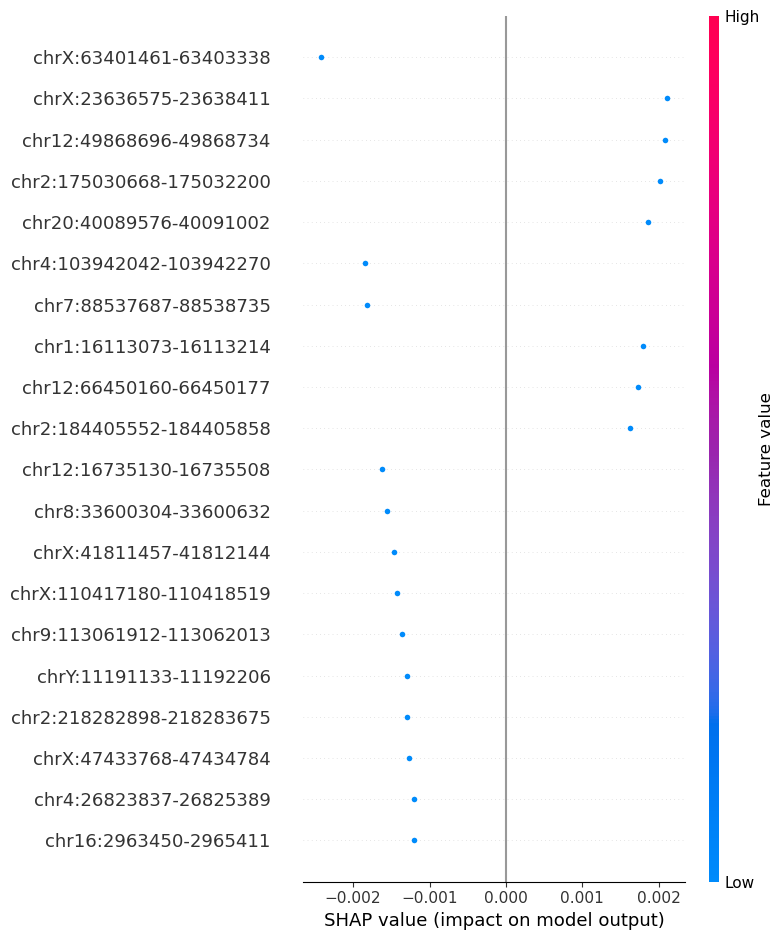

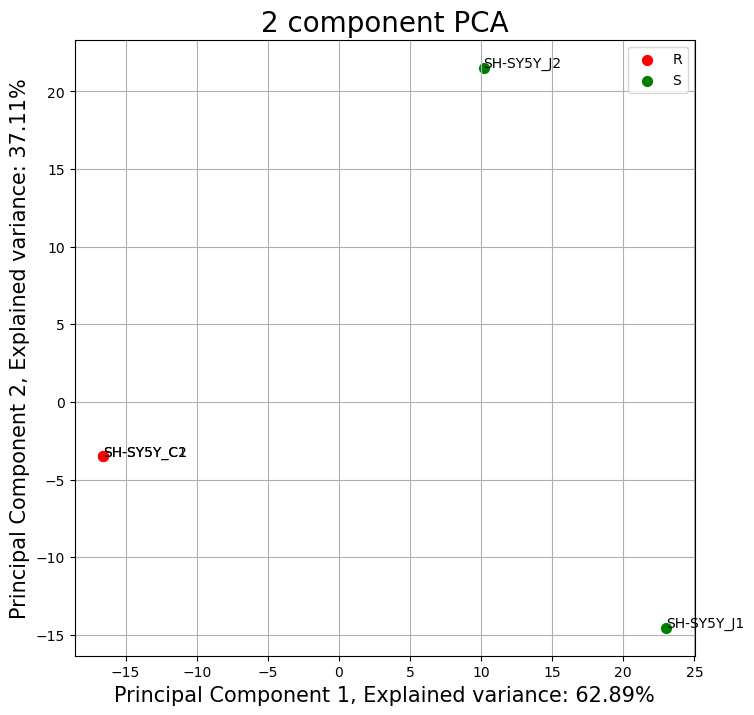

In [44]:
train_indices = [0, 1, 2]
test_indices = [3]
name = "wgbs_rob"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_wgbs_rob_fm, train_indices = train_indices, test_indices = test_indices, reg = True, dmr = "ttest")
save_model(model, train_indices, test_indices, name)

In [45]:
shap_wgbs_rob_df = train_and_predict_loo(meth_seg_wgbs_rob_fm, reg = True, dmr = "ttest")
shap_wgbs_rob_df_annot = find_annot_overlap(shap_wgbs_rob_df, rf_promotors_genes)
shap_wgbs_rob_df_annot.to_csv("/data/lvisser/shap/shap_wgbs_rob_df_annot.csv", index=False)

/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Average accuracy: 1.0


In [46]:
shap_wgbs_rob_df_annot = pd.read_csv("/data/lvisser/shap/shap_wgbs_rob_df_annot.csv")
print(shap_wgbs_rob_df_annot.shape)
shap_wgbs_rob_df_annot.head()

(157393, 10)


,segment_id,average_shap_value,reliability_shap_value,shap_variance,z_score,avg_meth_R,avg_meth_S,diff,direction,gene_symbol
0,chr3:179603818-179605408,-0.000774,0.000774,0.000002,17.401548,0.505,0.0,0.505,M,MRPL47
1,chr3:43690481-43692137,-0.000774,0.000774,0.000002,17.401548,0.505,0.0,0.505,M,ABHD5
2,chr3:38164784-38166370,-0.000774,0.000774,0.000002,17.401548,0.505,0.0,0.505,M,OXSR1
3,chr3:40505797-40506372,-0.000774,0.000774,0.000002,17.401548,0.505,0.0,0.505,M,ZNF620
4,chr19:33796789-33798114,-0.000774,0.000774,0.000002,17.401548,0.505,0.0,0.505,M,KCTD15


#### NB + MM

In [93]:
print(meth_seg_wgbs_nb1mm1_fm.shape)
meth_seg_wgbs_nb1mm1_fm.head()

(8, 1371922)


,sample_id_adj,chr22:10518304-10520219,chr22:10523473-10525269,chr22:10525487-10525747,chr22:10525749-10525946,chr22:10525988-10526067,chr22:10526088-10526125,chr22:10526140-10526166,chr22:10526193-10526215,chr22:10526292-10526901,...,chr9:138231832-138232715,chr9:138232777-138234470,chr9:138234518-138234560,chr9:138234662-138235402,chr9:138235579-138237577,chr9:138258705-138260224,chr9:138314410-138315935,source_directory,Group,tumor_type
0,SHP12dec_R4,0.00,0.04,0.84,0.95,0.79,0.88,0.70,0.92,0.83,...,0.20,0.16,0.79,0.16,0.33,0.00,0.11,data_OHMX20230016R_20231114,S,NB
1,SHY2sept_R1,0.00,0.19,0.81,0.55,0.49,0.24,0.73,0.35,0.56,...,0.59,0.72,0.38,0.38,0.73,1.00,0.86,data_OHMX20230016R_20231114,R,NB
2,IMR14nov_R1,1.00,1.00,1.00,0.98,0.93,1.00,1.00,1.00,0.98,...,0.80,0.84,0.80,0.62,0.89,0.84,0.73,data_OHMX20230016R_20231114,S,NB
3,SKN14nov_R2,0.09,0.16,0.71,0.56,0.72,0.25,0.82,0.07,0.44,...,0.33,0.24,0.25,0.00,0.25,0.16,0.30,data_OHMX20230016R_20231114,R,NB
4,JJN3_2_1,0.04,0.25,0.75,0.64,0.48,0.25,0.72,0.32,0.65,...,0.01,0.10,0.22,0.11,0.11,0.27,0.00,data_OHMX20230016R_MM_2,R,MM


Train: NB

Test: MM

DMR has removed 1313802 features of the original 1371918.
Regularization has removed 49518 features of the original 58116.
Sample: 0
Cell line: JJN3_2_1
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.9848291439471593
['S']: 0.015170856052840773

Sample: 1
Cell line: MM1R_4_3
True label: S (1)
Predicted label: S (1)
Probabilities:
['R']: 0.45948647150833233
['S']: 0.5405135284916677

Sample: 2
Cell line: RPMI8226_3_3
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.5893398548517282
['S']: 0.41066014514827176

Sample: 3
Cell line: OPM_4_3
True label: S (1)
Predicted label: R (0)
Probabilities:
['R']: 0.9096223977785861
['S']: 0.09037760222141392

PCA after filtering:


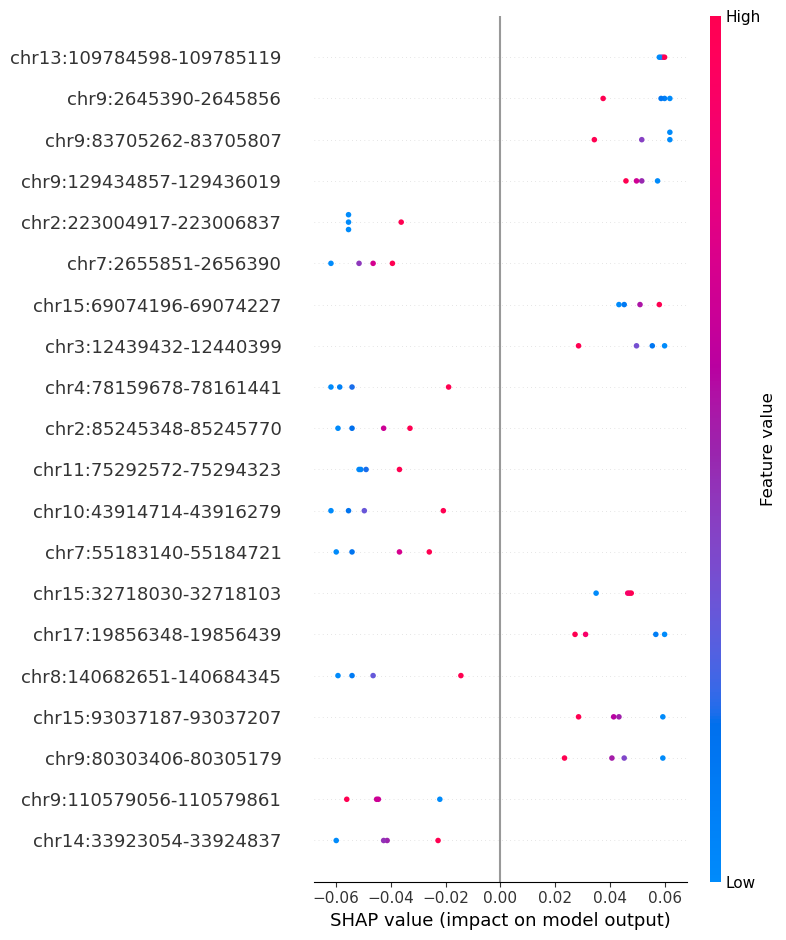

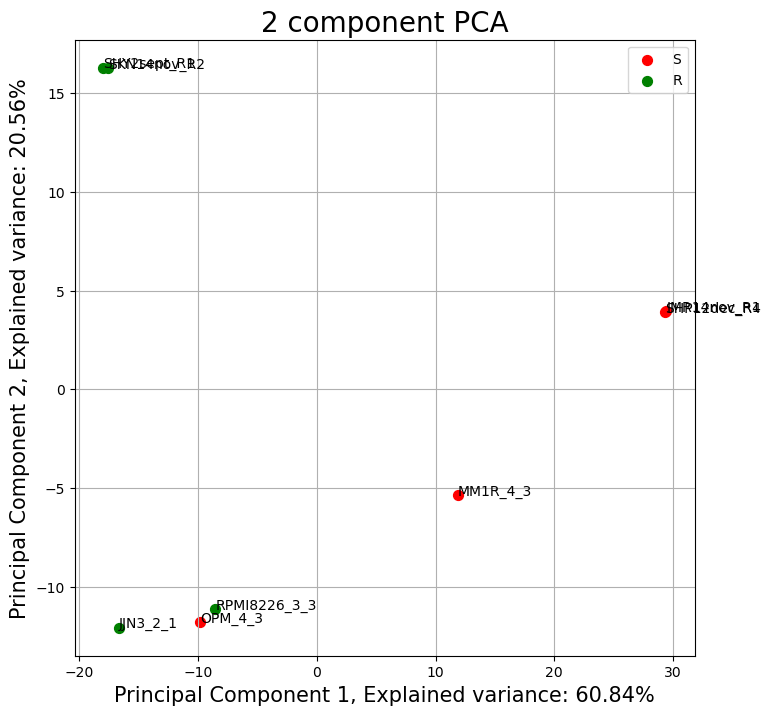

In [128]:
train_indices = [0, 1, 2, 3]
test_indices = [4, 5, 6, 7]
name = "wgbs_nb1mm1"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_wgbs_nb1mm1_fm, train_indices = train_indices, test_indices = test_indices, reg = True, dmr = "ttest")
save_model(model, train_indices, test_indices, name)

Train: MM

Test: NB

DMR has removed 1302111 features of the original 1371918.
Regularization has removed 60309 features of the original 69807.
Sample: 0
Cell line: SHP12dec_R4
True label: S (1)
Predicted label: R (0)
Probabilities:
['R']: 0.5798779710362473
['S']: 0.4201220289637527

Sample: 1
Cell line: SHY2sept_R1
True label: R (0)
Predicted label: S (1)
Probabilities:
['R']: 0.29874918081670876
['S']: 0.7012508191832912

Sample: 2
Cell line: IMR14nov_R1
True label: S (1)
Predicted label: S (1)
Probabilities:
['R']: 0.09448000300791592
['S']: 0.9055199969920841

Sample: 3
Cell line: SKN14nov_R2
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.5002162372872352
['S']: 0.49978376271276487

PCA after filtering:


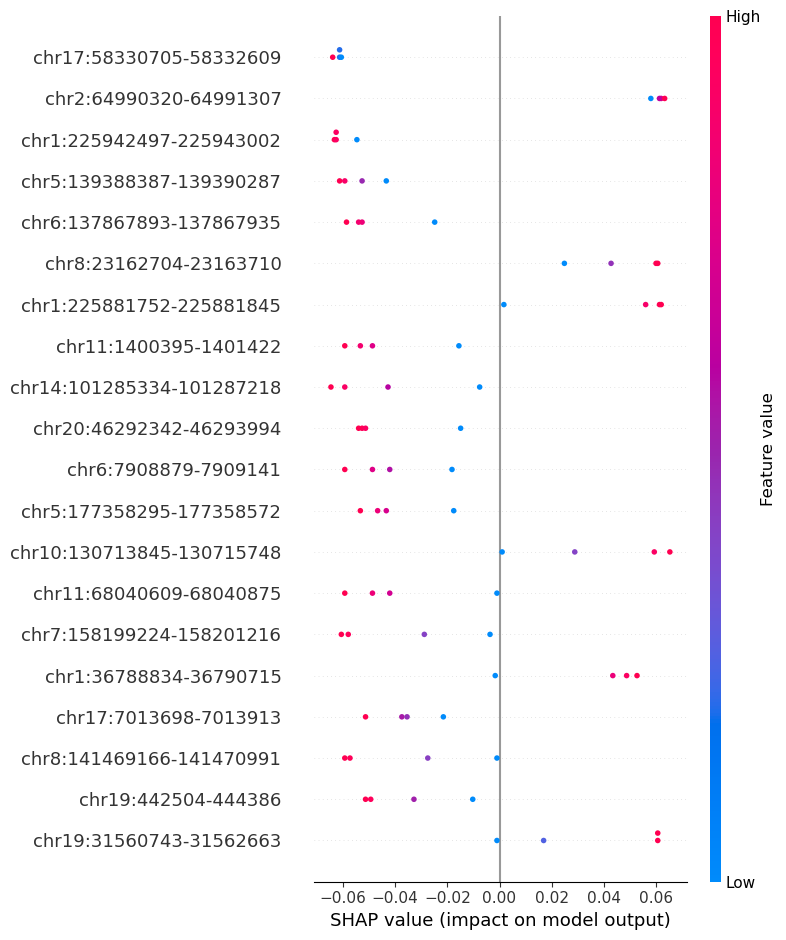

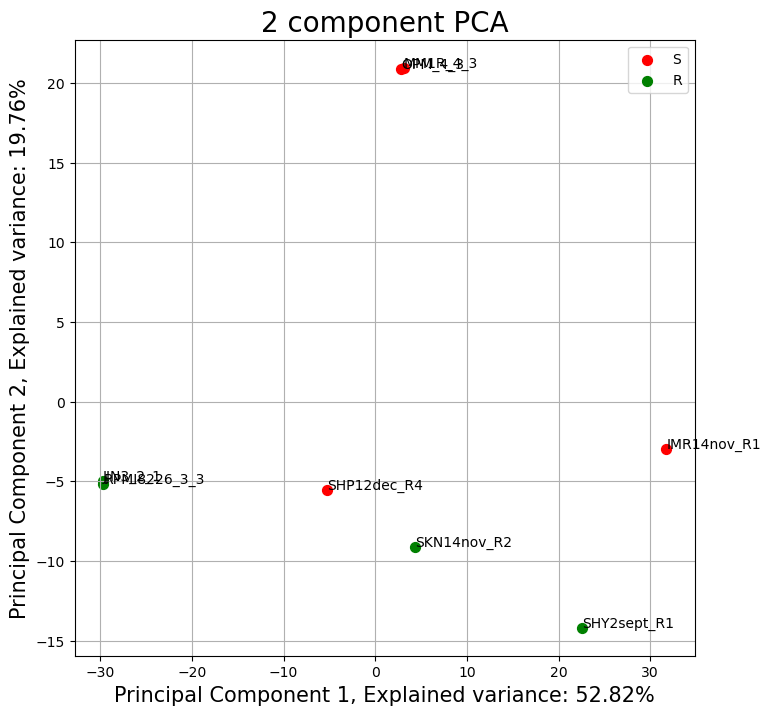

In [129]:
train_indices = [4, 5, 6, 7]
test_indices = [0, 1, 2, 3]
name = "wgbs_nb1mm1"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_wgbs_nb1mm1_fm, train_indices = train_indices, test_indices = test_indices, reg = True, dmr = "ttest")
save_model(model, train_indices, test_indices, name)

In [49]:
shap_wgbs_nb1mm1_df = train_and_predict_loo(meth_seg_wgbs_nb1mm1_fm, reg = True, dmr = "ttest")
shap_wgbs_nb1mm1_df_annot = find_annot_overlap(shap_wgbs_nb1mm1_df, rf_promotors_genes)
shap_wgbs_nb1mm1_df_annot.to_csv("/data/lvisser/shap/shap_wgbs_nb1mm1_df_annot.csv", index=False)

Average accuracy: 0.5


In [50]:
shap_wgbs_nb1mm1_df_annot = pd.read_csv("/data/lvisser/shap/shap_wgbs_nb1mm1_df_annot.csv")
print(shap_wgbs_nb1mm1_df_annot.shape)
shap_wgbs_nb1mm1_df_annot.head()

(10390, 9)


,segment_id,average_shap_value,reliability_shap_value,z_score,avg_meth_R,avg_meth_S,diff,direction,gene_symbol
0,chr6:31827691-31828104,0.030133,0.030133,33.038556,0.0,0.1750,-0.1750,U,HSPA1L
1,chr15:79896377-79897480,0.026641,0.026641,29.200706,0.0,0.1000,-0.1000,U,MTHFS
2,chrX:56390557-56392255,0.017097,0.017097,18.711381,0.0,0.2375,-0.2375,U,NaN
3,chr11:56604091-56606082,0.013497,0.013497,14.754324,0.0,0.1275,-0.1275,U,NaN
4,chr4:9373582-9375578,0.013312,0.013312,14.551746,0.0,0.2025,-0.2025,U,NaN


#### NB + Roberto

In [36]:
print(meth_seg_wgbs_nb1rob_fm.shape)
meth_seg_wgbs_nb1rob_fm.head()

(8, 1396691)


,sample_id_adj,chr22:10510235-10512049,chr22:10513853-10515736,chr22:10516017-10517750,chr22:10518304-10520219,chr22:10521531-10523474,chr22:10523565-10525269,chr22:10525487-10525647,chr22:10525675-10525908,chr22:10525917-10525931,...,chr9:138235444-138235580,chr9:138235594-138235929,chr9:138236806-138238555,chr9:138243705-138245697,chr9:138256260-138258070,chr9:138258705-138260388,chr9:138303904-138305610,source_directory,Group,tumor_type
0,SHP12dec_R4,0.04,0.02,0.15,0.00,0.11,0.04,0.85,0.93,0.89,...,0.44,0.31,0.15,0.00,0.00,0.00,0.86,data_OHMX20230016R_20231114,S,NB
1,SHY2sept_R1,0.04,0.08,0.00,0.00,0.00,0.21,0.85,0.63,0.34,...,0.94,0.37,0.92,0.88,1.00,1.00,0.92,data_OHMX20230016R_20231114,R,NB
2,IMR14nov_R1,0.88,0.92,1.00,1.00,1.00,1.00,1.00,0.98,1.00,...,0.94,0.88,0.91,0.95,0.76,0.84,1.00,data_OHMX20230016R_20231114,S,NB
3,SKN14nov_R2,0.06,0.07,0.00,0.09,0.04,0.17,0.71,0.63,0.17,...,0.58,0.05,0.31,0.39,0.25,0.16,0.32,data_OHMX20230016R_20231114,R,NB
4,SH-SY5Y_C2,0.03,0.08,0.08,0.20,0.03,0.08,0.81,0.72,0.48,...,0.90,0.26,0.83,0.87,1.00,1.00,0.97,data_OHMXroberto,R,NB


Train: NB

Test: Roberto

DMR has removed 1336870 features of the original 1396687.
Regularization has removed 51066 features of the original 59817.
Sample: 0
Cell line: SH-SY5Y_C2
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.5748490346004085
['S']: 0.4251509653995916

Sample: 1
Cell line: SH-SY5Y_C1
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.7843728003132417
['S']: 0.21562719968675823

Sample: 2
Cell line: SH-SY5Y_J1
True label: S (1)
Predicted label: R (0)
Probabilities:
['R']: 0.7709897863118714
['S']: 0.2290102136881286

Sample: 3
Cell line: SH-SY5Y_J2
True label: S (1)
Predicted label: R (0)
Probabilities:
['R']: 0.7996608285533765
['S']: 0.2003391714466235

PCA after filtering:


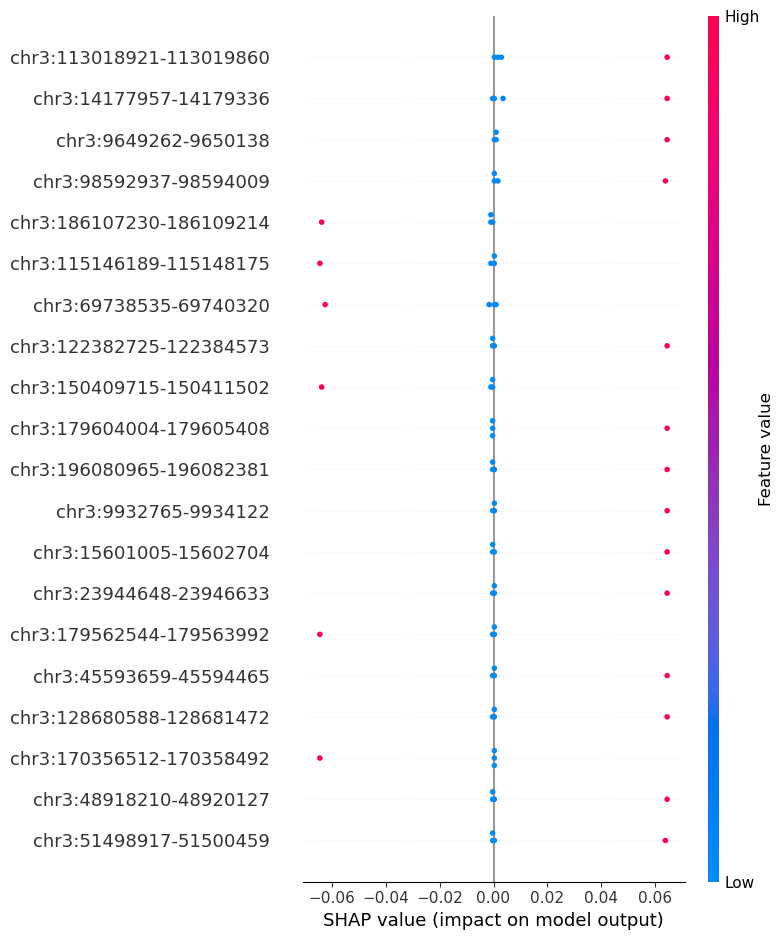

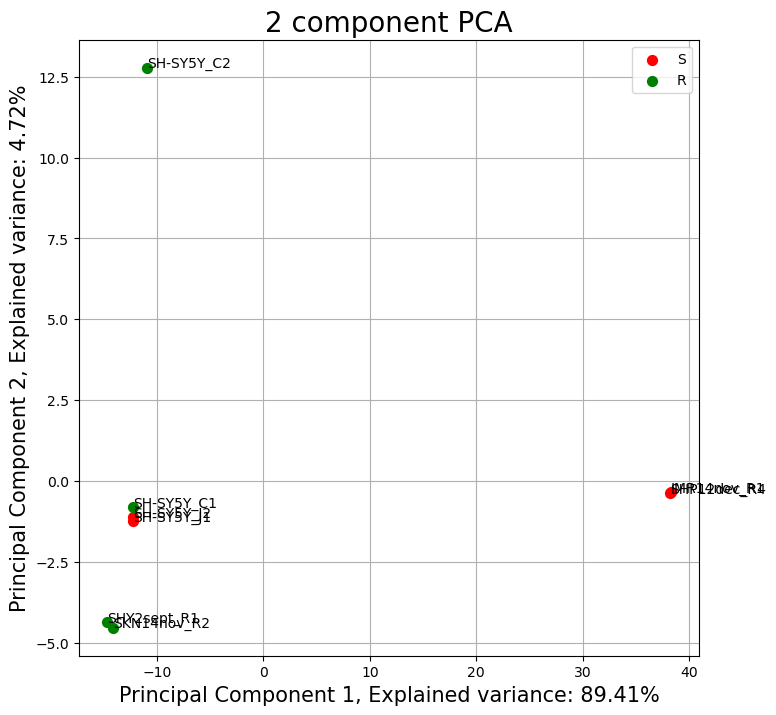

In [31]:
train_indices = [0, 1, 2, 3]
test_indices = [4, 5, 6, 7]
name = "wgbs_nb1rob"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_wgbs_nb1rob_fm, train_indices = train_indices, test_indices = test_indices, reg = True, dmr = "ttest")
save_model(model, train_indices, test_indices, name)

Train: Roberto

Test: NB

DMR has removed 1328299 features of the original 1396687.
Regularization has removed 58799 features of the original 68388.
Sample: 0
Cell line: SHP12dec_R4
True label: S (1)
Predicted label: R (0)
Probabilities:
['R']: 0.6231802652912978
['S']: 0.3768197347087022

Sample: 1
Cell line: SHY2sept_R1
True label: R (0)
Predicted label: S (1)
Probabilities:
['R']: 0.47334311966807263
['S']: 0.5266568803319274

Sample: 2
Cell line: IMR14nov_R1
True label: S (1)
Predicted label: R (0)
Probabilities:
['R']: 0.7464788231435626
['S']: 0.2535211768564373

Sample: 3
Cell line: SKN14nov_R2
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.7284121513512273
['S']: 0.2715878486487727

PCA after filtering:


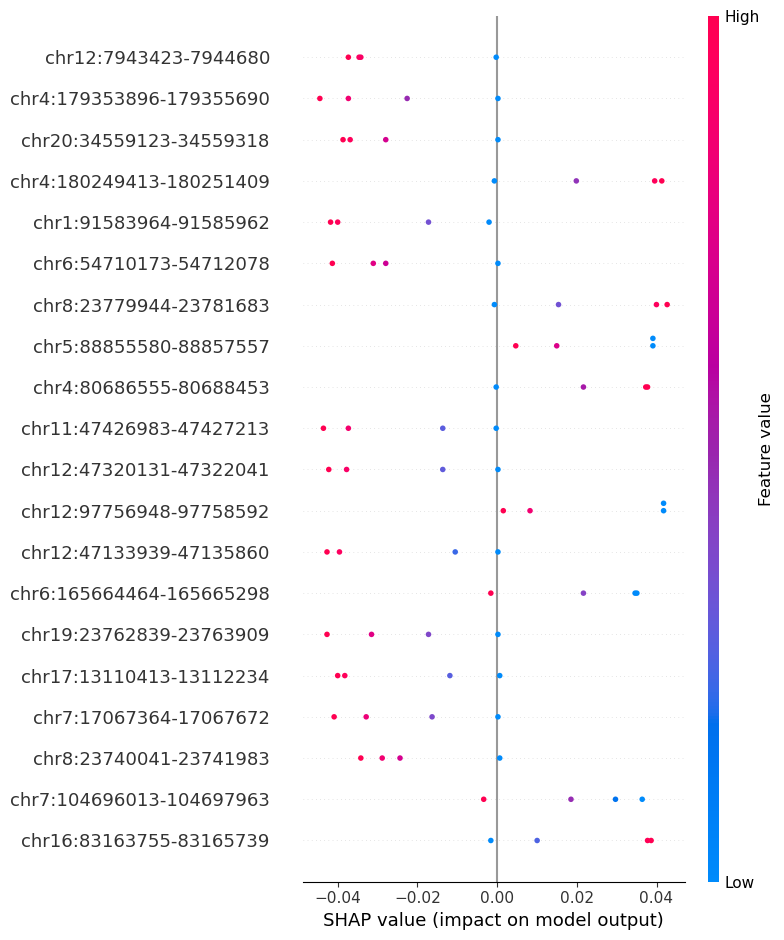

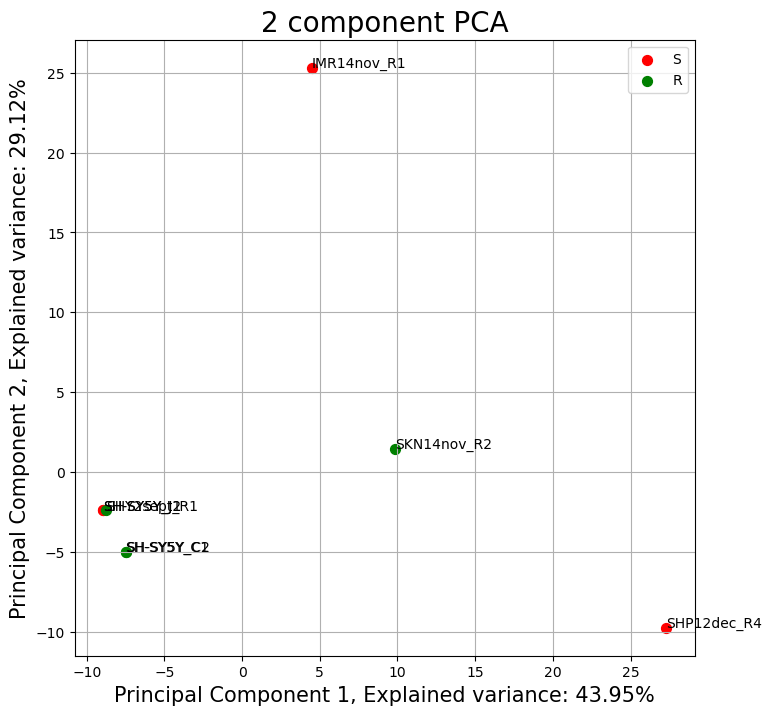

In [32]:
train_indices = [4, 5, 6, 7]
test_indices = [0, 1, 2, 3]
name = "wgbs_nb1rob"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_wgbs_nb1rob_fm, train_indices = train_indices, test_indices = test_indices, reg = True, dmr = "ttest")
save_model(model, train_indices, test_indices, name)

In [33]:
shap_wgbs_nb1rob_df = train_and_predict_loo(meth_seg_wgbs_nb1rob_fm, reg = True, dmr = "ttest")
shap_wgbs_nb1rob_df_annot = find_annot_overlap(shap_wgbs_nb1rob_df, rf_promotors_genes)
shap_wgbs_nb1rob_df_annot.to_csv("/data/lvisser/shap/shap_wgbs_nb1rob_df_annot.csv", index=False)

/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Average accuracy: 0.5


In [35]:
shap_wgbs_nb1rob_df_annot = pd.read_csv("/data/lvisser/shap/shap_wgbs_nb1rob_df_annot.csv")
print(shap_wgbs_nb1rob_df_annot.shape)
shap_wgbs_nb1rob_df_annot.head()

(3173, 10)


,segment_id,average_shap_value,reliability_shap_value,shap_variance,z_score,avg_meth_R,avg_meth_S,diff,direction,gene_symbol
0,chr9:135499549-135501425,-0.00106,0.009139,0.000084,7.190345,0.01,0.00,0.01,M,C9orf116
1,chr17:49677068-49678364,-0.00106,0.009139,0.000084,7.190345,0.00,0.01,-0.01,U,SPOP
2,chr17:3944839-3945104,-0.00106,0.009139,0.000084,7.190345,0.00,0.01,-0.01,U,NaN
3,chr19:48468692-48470062,-0.00106,0.009139,0.000084,7.190345,0.00,0.01,-0.01,U,CYTH2
4,chr10:1055644-1057401,-0.00106,0.009139,0.000084,7.190345,0.00,0.01,-0.01,U,WDR37
